# Summary
Online Shoppers Purchasing Intention Dataset을 가지고 Zero-R을 포함한 7가지의 classifier model을 만든다. 그 후, 분류 성능을 향상하기 위해 파라미터 변경 및 feature selection 등을 여러 모델에 적용시켜 본다.

feature selection은 전체 feature들 중 5 퍼센트 만큼 선택하여 돌려보고 성능을 측정한다. 그 후, 5퍼센트 씩 늘리면서 95 퍼센트 선택할 때 까지 반복한다. 그리고 가장 좋은 성능을 나타낸 feature selection을 고른다.

데이터에 어떤 feature들이 있는지 먼저 소개하고, correlation matrix를 통해 상관관계를 확인한다. 그 후 모델들을 만들어 성능을 비교하고 왜 그런 차이가 발생했는지 분석해본다.

한 종류의 모델에 대해 

1. default 모델
2. 파라미터 변경한 모델
3. feature selection 적용한 모델
4. 파라미터를 변경한 모델에 대해 feature selection 적용한 모델

총 4가지 모델이 나온다.

그 다음으로는 clustering을 통해 분류한 label과 classifier를 통해 분류한 label이 어떤 차이가 있는지 알아본다.

* feature selection을 할 때 퍼센트를 5단위로 늘려가면서 cross-validation을 하기 때문에 시간이 오래걸린다.

# Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz  
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Online Shoppers Purchasing Intention Dataset

과제에서 사용할 데이터는 'Online Shoppers Purchasing Intention Dataset'으로 총 18가지의 feature를 가지고 있다.

1. Administrative, Administrative_Duration, Informational, Informational_Duration, ProductRelated 그리고 ProductRelated_Duration은 해당 세션에서 방문자가 방문한 각 유형의 페이지 수와 각 페이지 카테고리에서 머무른 시간을 의미한다.
2. BounceRates는 사이트에 들어간 다음 해당 세션 동안 다른 요청을 하지 않고 나가는 비율을 의미한다.
3. ExitRates은 모든 페이지에 대해 그 페이지가 세션에서 마지막인 비율을 의미한다.
4. PageValues는 사용자가 e-commerce transaction을 완료하기 전에 방문한 웹페이지들의 평균 값을 의미한다.
5. SpecailDay는 특정날짜(어버이날, 발렌타인데이 등)에 방문 근접성을 의미한다. 이는 주문일과 배송일 사이의 기간과 같은 것을 고려하여 결정된다. 발렌타인 데이를 예로 들어보면, 2월 2일 부터 12일까지는 nonzero값을 가지고, 그 전후로는 0이 된다.
6. OperatingSystems, Browser, Region, TrafficType, VisitorTypes, Weekend, Month 등의 column들도 있다.
7. Revenue는 최종 구매를 했는지 여부를 의미한다.

이 데이터셋을 택한 이유는 분류하기에 적절한 모델 같다고 생각했다. 이번 과제는 classifier와 clustering이 주가 되는데, revenue를 label로 두고 분류하면 좋을 것 같았다. 또한, clustering을 할 때에도 주어진 label이 없을 때 보단 이미 label이 있는 데이터가 어떻게 묶이는지 실제 label과 차이를 찾는게 더 재미있을 것 같았다. 그리고, feature수도 적당하다고 생각했다. 기존의 feature에서 몇 개의 column을 이진 데이터로 변경하면 feature수가 더 많아질 수 있을 것이라고 생각했다. 무엇보다도 어떤 session이 최종적으로 구매를 하게 되는지 주제 자체가 흥미로워서 이 데이터 셋을 택했다.

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
data = pd.read_csv(url)

data    # revenue가 label로

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [5]:
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


# Data Preprocessing
위에서 볼 수 있듯이 Nan데이터 즉 결측값은 없다.
대부분의 column들은 실수형이지만, Month, VisitorType는 object 타입이고, Weekend, Revenue는 bool 값이므로 연산이 가능한 숫자 값으로 바꿔줘야한다.

먼저 각 column들이 어떤 값들을 갖는지 확인해보면 다음과 같다.

In [6]:
mcount = Counter(data['Month'])
print(mcount)

vcount = Counter(data['VisitorType'])
print(vcount)

wcount = Counter(data['Weekend'])
print(wcount)

rcount = Counter(data['Revenue'])
print(rcount)

Counter({'May': 3364, 'Nov': 2998, 'Mar': 1907, 'Dec': 1727, 'Oct': 549, 'Sep': 448, 'Aug': 433, 'Jul': 432, 'June': 288, 'Feb': 184})
Counter({'Returning_Visitor': 10551, 'New_Visitor': 1694, 'Other': 85})
Counter({False: 9462, True: 2868})
Counter({False: 10422, True: 1908})


- Month column에는 각 달의 약어. Feb, Mar 등
- VisitorType column에는 Returning_Visitor, New_Visitor, Other
- Weekend와 Revenue에는 True와 False

In [7]:
data = pd.concat([data, pd.get_dummies(data['Month'], prefix='Month')], axis=1).drop(['Month'], axis=1)
data = pd.concat([data, pd.get_dummies(data['VisitorType'], prefix='VisitorType')], axis=1).drop(['VisitorType'], axis=1)

data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,1,1,1,1,False,False,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,1,2,False,False,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,4,1,9,3,False,False,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,3,2,2,4,False,False,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,3,3,1,4,True,False,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,4,6,1,1,True,False,0,1,0,0,0,0,0,0,0,0,0,0,1
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,3,2,1,8,True,False,0,0,0,0,0,0,0,1,0,0,0,0,1
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,3,2,1,13,True,False,0,0,0,0,0,0,0,1,0,0,0,0,1
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,2,2,3,11,False,False,0,0,0,0,0,0,0,1,0,0,0,0,1


In [8]:
data = data.drop(['VisitorType_Other'], axis=1)

In [9]:
le = LabelEncoder()
data.Weekend = le.fit_transform(data.Weekend)
data.Revenue = le.fit_transform(data.Revenue)

data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,4,1,9,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,3,2,2,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,3,3,1,4,1,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,4,6,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,3,2,1,8,1,0,0,0,0,0,0,0,0,1,0,0,0,1
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,3,2,1,13,1,0,0,0,0,0,0,0,0,1,0,0,0,1
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,2,2,3,11,0,0,0,0,0,0,0,0,0,1,0,0,0,1


위와 같이
- object 타입은 기존의 column을 삭제하고, 각 값에 해당하는 column을 만들고 값은 0또는 1을 갖도록 한다.
- bool 타입은 LabelEncoder를 통해서 True는 1이 되고, False는 0이 되도록 수정한다.

object 타입을 int 또는 float 값으로 바꿀 때 주의해야한다. 예를 들어 object 타입도 bool 타입 처럼 encoder를 통해 변환한다면, 변환된 값은 실수값이 되겠지만 그 값은 아무런 의미도 갖지 않는다. 예를 들어 Month column을 Weekend column처럼 encoder를 통해 변환했을 때 1월이 4라는 값을 갖게 된다고 하자. 원래의 데이터는 1월을 의미하는 거지만 변경된 값은 4라는 숫자를 갖지만 아무 의미도 없게 된다. 즉 **object 타입을 기계적으로 encoder를 통해 변경하는 경우 원래 데이터가 갖는 의미를 잃게 될 수도 있다.** 따라서 이 점을 주의하며 전처리를 했다.

OperatingSystems, Browser, Region 그리고 TrafficType은 int형 값을 가지지만 그 숫자가 의미를 갖는 것이 아니라 타입(종류)를 나타내기 위한 것이다. 따라서 아래와 같은 처리를 해주기로했다.
- 숫자가 실제 숫자의 의미를 갖는 것이 아니라 그저 구분을 하기 위한 것이므로, 어떤 값이 데이터에서 나타나는 비율이 너무 적은 것들을 기타를 의미하는 0으로 바꿔준다.
- 예를 들어 OperatingSystems이 4보다 큰 값을 가지는 데이터는  (8: 79, 6: 19, 7: 7, 5: 6) 와 같이 매우 적기 때문에 기타의 의미로 8, 6, 7, 5에 대해서는 0으로 바꿔준다.
- 바꾼 후 Month를 처리했을 때와 마찬가지로 기존의 column을 제거하고 각 값들을 column으로 추가하여 0또는 1의 값을 가지는 이진 데이터로 변환한다. 

In [10]:
oscount = Counter(data['OperatingSystems'])
print(oscount)

brcount = Counter(data['Browser'])
print(brcount)

recount = Counter(data['Region'])
print(recount)

trcount = Counter(data['TrafficType'])
print(trcount)

Counter({2: 6601, 1: 2585, 3: 2555, 4: 478, 8: 79, 6: 19, 7: 7, 5: 6})
Counter({2: 7961, 1: 2462, 4: 736, 5: 467, 6: 174, 10: 163, 8: 135, 3: 105, 13: 61, 7: 49, 12: 10, 11: 6, 9: 1})
Counter({1: 4780, 3: 2403, 4: 1182, 2: 1136, 6: 805, 7: 761, 9: 511, 8: 434, 5: 318})
Counter({2: 3913, 1: 2451, 3: 2052, 4: 1069, 13: 738, 10: 450, 6: 444, 8: 343, 5: 260, 11: 247, 20: 198, 9: 42, 7: 40, 15: 38, 19: 17, 14: 13, 18: 10, 16: 3, 12: 1, 17: 1})


In [11]:
def osagg(x):
  if x > 4:
    return 0
  else:
    return x

def bragg(x):
  if x >= 11 or x==7 or x == 9:
    return 0
  else:
    return x

def tragg(x):
  if x >= 14 or x == 9 or x == 7 or x == 12:
    return 0
  else:
    return x

In [12]:
data['OperatingSystems'] = data['OperatingSystems'].apply(osagg)
data['Browser'] = data['Browser'].apply(bragg)
data['TrafficType'] = data['TrafficType'].apply(tragg)

In [13]:
oscount = Counter(data['OperatingSystems'])
print(oscount)

brcount = Counter(data['Browser'])
print(brcount)

recount = Counter(data['Region'])
print(recount)

trcount = Counter(data['TrafficType'])
print(trcount)

Counter({2: 6601, 1: 2585, 3: 2555, 4: 478, 0: 111})
Counter({2: 7961, 1: 2462, 4: 736, 5: 467, 6: 174, 10: 163, 8: 135, 0: 127, 3: 105})
Counter({1: 4780, 3: 2403, 4: 1182, 2: 1136, 6: 805, 7: 761, 9: 511, 8: 434, 5: 318})
Counter({2: 3913, 1: 2451, 3: 2052, 4: 1069, 13: 738, 10: 450, 6: 444, 0: 363, 8: 343, 5: 260, 11: 247})


In [14]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,4,1,9,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,3,2,2,4,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,3,3,1,4,1,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,4,6,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,3,2,1,8,1,0,0,0,0,0,0,0,0,1,0,0,0,1
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,3,2,1,13,1,0,0,0,0,0,0,0,0,1,0,0,0,1
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,2,2,3,11,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [15]:
data = pd.concat([data, pd.get_dummies(data['OperatingSystems'], prefix='OperatingSystems')], axis=1).drop(['OperatingSystems'], axis=1)
data = pd.concat([data, pd.get_dummies(data['Browser'], prefix='Browser')], axis=1).drop(['Browser'], axis=1)
data = pd.concat([data, pd.get_dummies(data['Region'], prefix='Region')], axis=1).drop(['Region'], axis=1)
data = pd.concat([data, pd.get_dummies(data['TrafficType'], prefix='TrafficType')], axis=1).drop(['TrafficType'], axis=1)

data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,Browser_0,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_8,Browser_10,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_0,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_8,TrafficType_10,TrafficType_11,TrafficType_13
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


classification을 하기 위해서 label(y)과 feature(X)로 나눠준다.

In [16]:
X = data.drop(['Revenue'], axis=1)
y = data['Revenue']

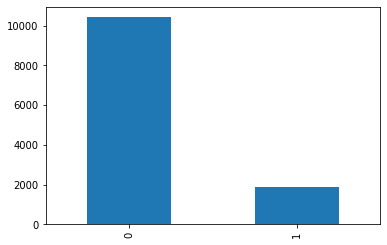

In [17]:
y.value_counts().plot.bar()

y 데이터 즉 label을 시각화하면 위의 그래프와 같다. 즉 주어진 데이터는 label이 0인 데이터가 더 많은 편향된 데이터이다.



# Correlation Matrix

In [18]:
corr_df = data.corr()

corr_df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,Browser_0,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_8,Browser_10,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_0,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_8,TrafficType_10,TrafficType_11,TrafficType_13
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.098990,-0.094778,0.026417,0.138917,0.047159,-0.014443,-0.065649,0.006221,-0.001902,-0.055036,-0.064587,0.051574,0.091266,0.059607,0.028449,-0.022884,-0.017057,-0.013718,0.016527,0.000889,-0.007292,-0.006052,-0.019786,0.046655,-0.027128,-0.025143,-0.003221,-0.014250,-0.028988,-0.000293,-0.010499,0.008524,0.019395,-0.001205,0.007205,-0.020629,0.003060,0.009569,-0.016176,-0.013203,-0.060721,0.117913,-0.069011,0.003131,0.051673,-0.016373,0.028640,0.001195,-0.023847,-0.040306
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.067608,-0.073304,0.014990,0.093587,0.027950,-0.004990,-0.044524,-0.002096,-0.018974,-0.023198,-0.039318,0.032432,0.055101,0.031313,0.025043,-0.022525,-0.007851,0.014410,-0.025389,0.029231,-0.022322,-0.007123,0.000203,0.017828,-0.008755,-0.016952,-0.010182,0.001071,-0.011477,-0.000500,-0.005269,0.010926,0.006171,0.004098,0.006791,-0.018280,-0.002969,0.009469,-0.009203,0.003528,-0.042526,0.096927,-0.062035,-0.009681,0.021620,-0.012112,0.021860,-0.004729,-0.014805,-0.018519
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.048632,-0.048219,0.035785,0.095200,0.005882,0.002822,-0.040372,0.001896,0.007176,-0.027957,-0.038422,0.063754,-0.002619,0.009692,-0.053429,0.057399,-0.016155,-0.004192,0.000633,0.018178,-0.023058,-0.015149,-0.006355,0.042466,-0.017286,-0.027661,-0.017450,-0.008457,-0.030056,-0.005636,0.026205,-0.014584,0.002890,0.001905,-0.008917,0.000679,-0.011733,-0.007813,-0.023811,-0.013144,-0.050121,0.126564,-0.071547,-0.001206,-0.003523,-0.007740,-0.000669,0.003539,-0.014758,-0.026282
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.030861,-0.030577,0.024078,0.070345,0.001412,0.010314,-0.028060,0.014958,-0.015407,-0.011545,-0.031811,0.036899,0.006434,0.001744,-0.043200,0.045501,-0.011483,-0.013472,0.022901,-0.004067,-0.016603,-0.009232,-0.018090,0.035989,-0.009420,-0.017116,-0.011341,0.003712,-0.022935,-0.000137,0.015875,0.003463,0.002515,0.004300,-0.003630,-0.008572,-0.014422,-0.002229,-0.022195,-0.001580,-0.039117,0.099818,-0.048034,-0.008446,-0.015972,-0.007477,0.008161,-0.005626,-0.014581,-0.020533
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.056282,-0.023958,0.016092,0.158538,0.027999,-0.033909,-0.056863,0.020034,0.015072,-0.114672,-0.072220,0.182339,0.008907,0.005997,-0.122727,0.128738,-0.033231,-0.093192,0.123701,-0.060551,0.020305,-0.029042,-0.082281,0.092916,-0.031909,-0.007261,-0.001773,-0.004998,-0.032433,0.002950,0.037020,-0.009338,0.003919,-0.011153,-0.007692,-0.023134,-0.001566,-0.021488,-0.011709,-0.034852,0.002094,0.098023,-0.059537,-0.022209,-0.045696,-0.009228,-0.021334,0.005065,-0.020964,0.006897
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.052823,-0.036380,0.007311,0.152373,0.007767,-0.017563,-0.046550,0.002276,0.001506,-0.085491,-0.068133,0.166951,-0.008773,0.005950,-0.116447,0.120489,-0.023109,-0.088223,0.121582,-0.059997,0.009188,-0.020837,-0.076937,0.082812,-0.023312,-0.004648,-0.002085,-0.000176,-0.031380,0.001551,0

In [19]:
corr_abs = np.abs(corr_df['Revenue'])
corr_abs.sort_values(axis=0)

Browser_8                        0.000236
TrafficType_4                    0.000336
Month_Jul                        0.001036
Region_7                         0.001155
Region_5                         0.003949
Browser_2                        0.004183
Region_4                         0.006024
Region_9                         0.007792
Browser_1                        0.008965
OperatingSystems_0               0.009077
Region_2                         0.009468
Month_Aug                        0.010959
Region_6                         0.011410
OperatingSystems_1               0.011577
OperatingSystems_4               0.012816
Region_3                         0.012937
Browser_6                        0.013167
Browser_10                       0.013305
Region_8                         0.013579
TrafficType_11                   0.014050
Browser_0                        0.014098
Region_1                         0.014416
Browser_4                        0.015247
Browser_5                        0

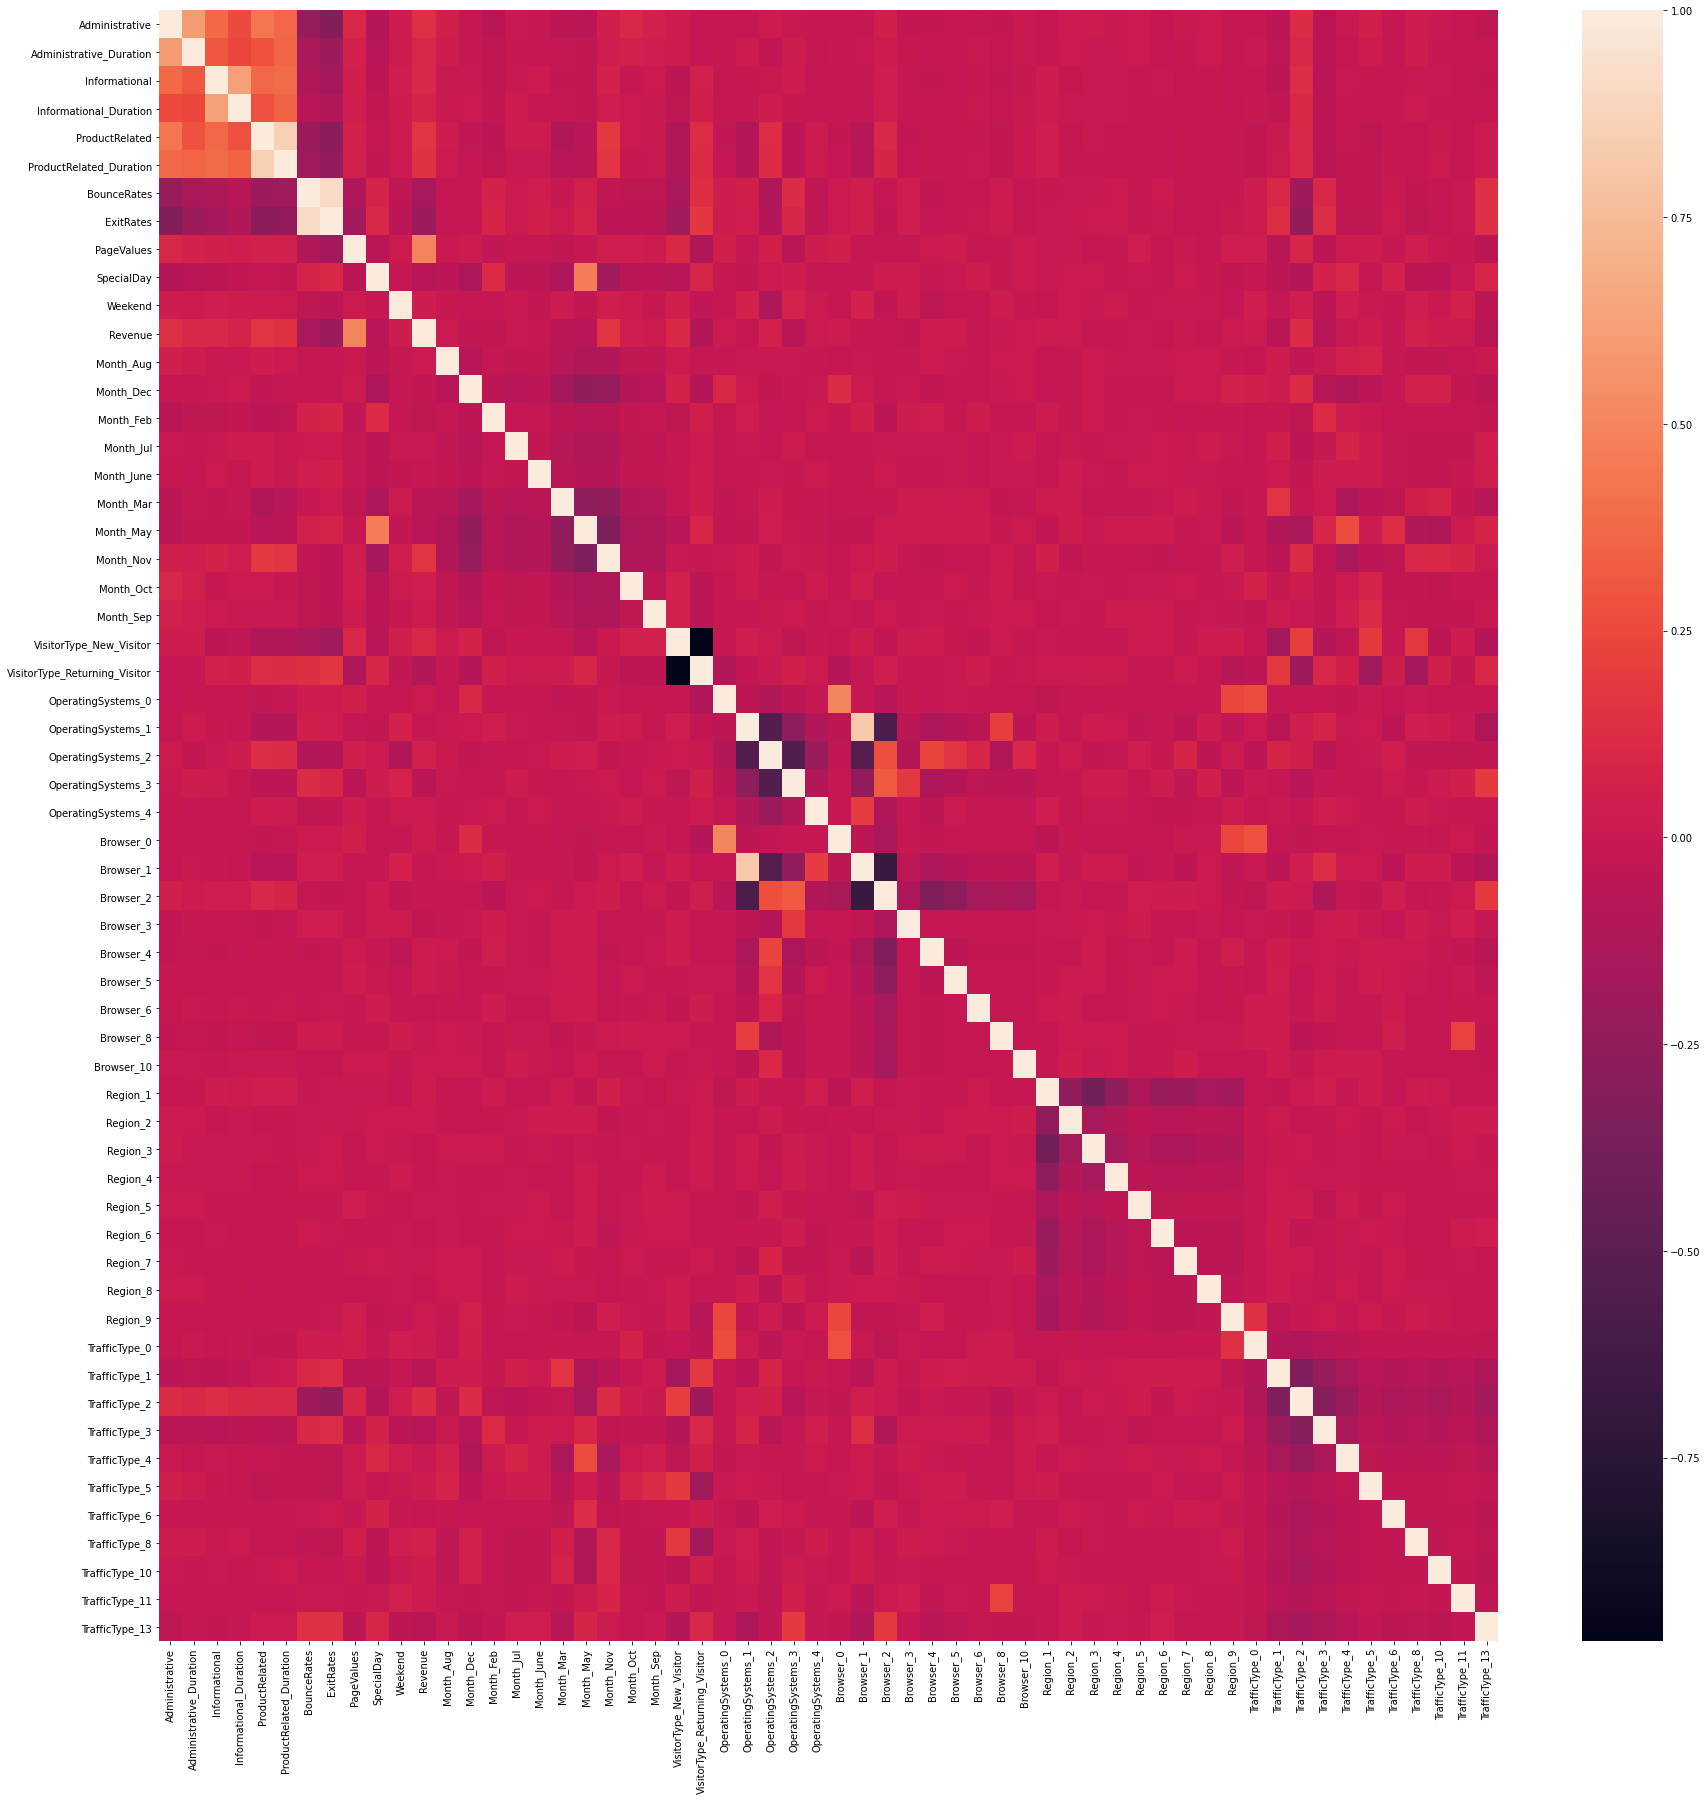

In [20]:
plt.figure(figsize = (30,30))
sns.heatmap(data.corr())

각 상관계수들을 구하면 위와 같은 표를 구할 수 있다. 이를 한 눈에 보기 쉽게 하기 위해서 시각화하면 다음과 같다.

위의 그래프를 보면, -1부터 1 사이에 상관계수들을 한 눈에 볼 수 있다. 대각선을 기준으로 양쪽은 서로 대칭이기 때문에 아래의 삼각형만 보거나 위의 삼각형만 봐도 무방하다. 

이 때 주의할 점은, 상관계수는 어떤 feature가 증가할 때 다른 하나가 증가하거나 감소한다는 의미를 나타내지 둘 사이에 어떤 인과관계가 있다는 것은 아니다.

Revenue와 상관 계수 절댓값이 가장 큰 feature는 PageValues이고 그 뒤로는 ExitRates, ProductRelated, Month_Nov, ProductRelated_Duration, BounceRates, VisitorType_Returning_Visitor, VisitorType_New_Visitor, TrafficType_2 그리고 Administrative 등이 있다.

아마 feature selection을 통해서 이 상관계수의 절댓값이 큰 feature들이 선택될 가능성이 높을 것이다.

# Functions for FS
아래 정의된 함수들은 각 분류 모델에서 feature selection을 위해 사용되는 함수들이다.

- fs_score 함수는 feature selction을 위한 코드로, feature들 중 5~95퍼센트를 선택 했을 때 몇 퍼센트를 선택했을 때 가장 좋은 성능을 보이는지 알기 위한 함수이다. 5퍼센트에서 95퍼센트까지 5퍼센트씩 증가하며 feature를 선택하며, 선택한 feature에 대한 모델의 정확도를 저장하고, 그 리스트를 return한다.
- print_feature 함수는 fs_score 함수에서 정확도가 가장 높았을 때 어떤 feature들을 택했는지를 보여준다.
- make_selected_model 함수는 2가지를 return한다. classifier model을 input으로 받아서 feature selection을 한 데이터로 학습시킨 model과 select를 return 한다.
- make_score_df 함수는 model을 input으로 받아서 여러가지 점수를 dataframe 형식으로 저장한다.

In [21]:
percent = np.arange(5, 100, 5)

def fs_score(model, x_train, y_train):   # FS
  score_lst = np.array([])

  for i in percent:
    select = SelectPercentile(score_func=f_classif, percentile=i)  
    select.fit(x_train, y_train)

    x_train_selected = select.transform(x_train)    # feature 선택해서 거른거
    score_lst = np.append(score_lst, cross_val_score(model, x_train_selected, y_train, cv=5).mean())

  plt.plot(percent, score_lst)
  
  return score_lst    # feature percent마다 score

In [22]:
def print_feature(scorelst, x_train, y_train):
  select = SelectPercentile(score_func=f_classif, percentile=percent[np.argmax(scorelst)])  
  select.fit(x_train, y_train)

  mask = select.get_support()

  column_lst = np.array([])
  for i in range(len(mask)):
    if mask[i] == True:
      column_lst = np.append(column_lst, X.columns[i])

  return column_lst    # 선택한 feature들

In [23]:
def make_selected_model(scorelst, model, x_train):
  select = SelectPercentile(score_func=f_classif, percentile=percent[np.argmax(scorelst)])
  select.fit(x_train, y_train)

  x_train_selected = select.transform(x_train)
  
  model.fit(x_train_selected, y_train)
  
  return model, select  # selected data로 학습 시킨 model return

In [24]:
def make_score_df(model_name, y_test, y_pred, test_score, train_score):
  acc = accuracy_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  pre = precision_score(y_test, y_pred)
  f1s = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)

  score_dict = {'model': [model_name], 'train': [train_score], 'test': [test_score],
                'accuracy': [acc], 'recall': [rec], 'precesion': [pre], 'f1 score': [f1s], 'auc': [auc]}

  return pd.DataFrame(score_dict)

# Standard Scaler
모델들을 학습시키고 성능을 평가하기 위해 train data와 test data로 나눈다.
- 나누기 전에 이 데이터는 어떤 column은 이진 데이터이고, 어떤 데이터는 시간, 어떤 데이터는 갯수를 나타낸다. 즉, 단위가 다르기 때문에 이를 표준화해줘야한다. 

In [25]:
x_stand = StandardScaler().fit_transform(X)   # x 표준화

x_train, x_test, y_train, y_test = train_test_split(x_stand, y, test_size=0.3, random_state=42)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [26]:
x_selected_train = pd.DataFrame(x_train, columns=X.columns)[['ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov']]
x_selected_test = pd.DataFrame(x_test, columns=X.columns)[['ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov']]

## 1. ZERO-R

 ZeroR은 예측 성능은 없지만,다른 모델들의 성능의 기준점이 된다. ZeroR은 feature는 이용하지 않고, label값만 보고 결정한다. 이 데이터의 ZeroR값은 아래와 같고, 앞으로 만들 다른 모델들의 성능은 이보다는 좋아야한다.

In [27]:
y.value_counts()/y.shape[0]*100

0    84.525547
1    15.474453
Name: Revenue, dtype: float64

## 2. Logistic Regression

### 2.1 Default

In [28]:
logistic = LogisticRegression(max_iter=10000, random_state=42)
logistic.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
print(logistic.score(x_train, y_train))
print(logistic.score(x_test, y_test))

0.8861082145753678
0.8791565287915653


In [30]:
logistic.coef_

array([[-0.04172647,  0.00493851,  0.08360611, -0.01034871,  0.00579302,
         0.17481919, -0.08657628, -0.82993815,  1.49077134, -0.06396068,
         0.02283603,  0.05534096, -0.13804481, -0.24210262,  0.05714678,
        -0.01391339, -0.15915687, -0.10917045,  0.31644601,  0.07296438,
         0.07505578,  0.14516337,  0.0793364 , -0.09346996,  0.07623626,
         0.02465553, -0.09255237,  0.01560106,  0.08160064, -0.044804  ,
         0.01182737, -0.06760912,  0.02564257,  0.03696589, -0.04157014,
        -0.00277482,  0.02002788,  0.01910645,  0.04085339, -0.01543501,
        -0.0136049 , -0.06196363,  0.06415273, -0.0119172 ,  0.00596413,
        -0.0765737 , -0.00255301,  0.0325314 ,  0.02388218, -0.07567188,
         0.02364097,  0.01928661, -0.0291948 ,  0.08920448,  0.08386457,
         0.07356056, -0.16933618]])

In [31]:
lr_score = make_score_df('LR', y_test, logistic.predict(x_test), logistic.score(x_test, y_test), logistic.score(x_train, y_train))

In [32]:
lr_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,LR,0.886108,0.879157,0.879157,0.349565,0.733577,0.473498,0.663099


Text(0.5, 15.0, 'Predicted label')

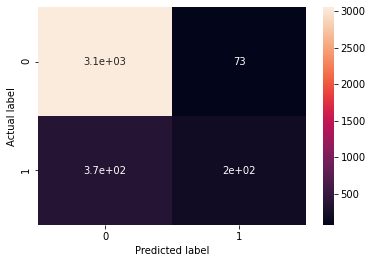

In [33]:
sns.heatmap(confusion_matrix(y_test, logistic.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 2.2 with Threshold
사이킷런에서 제공하는 함수의 threshold는 0.5이다.
model의 predict_proba 함수를 이용해서 class 1에 속할 확률을 구하고 변경된 threshold값을 기준으로 분류한다.

In [34]:
def cal_metrics(labels, predicts):
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0
  for i in range(len(predicts)):
    if labels[i] == 1 and predicts[i] == 1:
      true_positive += 1
    if labels[i] == 0 and predicts[i] == 0:
      true_negative += 1
    if labels[i] == 0 and predicts[i] == 1:
      false_positive += 1
    if labels[i] == 1 and predicts[i] == 0:
      false_negative += 1

  return true_positive, true_negative, false_positive, false_negative

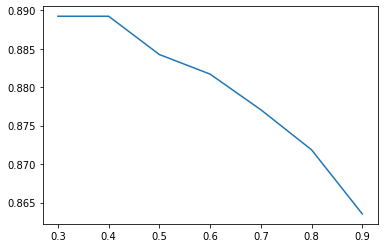

In [35]:
threshold_lst = np.arange(0.3, 0.9, 0.1)
threshold_score = np.array([])

logistic_threshold = LogisticRegression(max_iter=10000, random_state=42)

for i in threshold_lst:
  skf = StratifiedKFold(n_splits=5)
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(x_train, y_train):    # train data를 validation set으로 나눠
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]     
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    logistic_threshold.fit(x_train_cv, y_train_cv)      # validation set의 train set으로  학습
    predict_proba = logistic_threshold.predict_proba(x_val_cv)   # 확률 예측
    predict_proba = predict_proba[:,1]
    predict_y = np.where(predict_proba >= i, 1, 0)      # threshold를 기준으로 1, 0 분류

    TP, TN, FP, FN = cal_metrics(y_val_cv, predict_y) 
    val_accuracy = np.append(val_accuracy, (TP + TN) / len(predict_y))    # accuracy
  threshold_score = np.append(threshold_score, val_accuracy.mean())

plt.plot(threshold_lst, threshold_score)

In [36]:
print(threshold_score)
print(threshold_lst[np.argmax(threshold_score)])
print(np.max(threshold_score))

[0.88923739 0.88923739 0.88425551 0.88170627 0.87707167 0.87185784
 0.86351566]
0.3
0.8892373931579488


              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3124
           1       0.66      0.53      0.59       575

    accuracy                           0.88      3699
   macro avg       0.79      0.74      0.76      3699
weighted avg       0.88      0.88      0.88      3699



Text(0.5, 15.0, 'Predicted label')

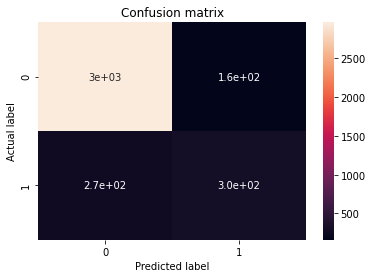

In [37]:
logistic_threshold = LogisticRegression(max_iter=10000, random_state=42)

logistic_threshold.fit(x_train, y_train)
predict_y_proba = logistic_threshold.predict_proba(x_test)
predict_y_proba = predict_y_proba[:,1]

predict_y = np.where(predict_y_proba >= threshold_lst[np.argmax(threshold_score)], 1, 0)

TP, TN, FP, FN = cal_metrics(y_test, predict_y) 

print(classification_report(y_test, predict_y))               # threshold 0.3

sns.heatmap(confusion_matrix(y_test, predict_y), annot=True)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [38]:
predict_train_y_praoba = logistic_threshold.predict_proba(x_train)
predict_train_y_praoba = predict_train_y_praoba[:,1]
predict_train_y = np.where(predict_train_y_praoba >= threshold_lst[np.argmax(threshold_score)], 1, 0)

TP_tr, TN_tr, FP_tr, FN_tr = cal_metrics(y_train, predict_train_y)

In [39]:
lr_th_score_dict = {'model': ['LR_threshold'], 'train': [(TP_tr + TN_tr)/len(y_train)], 'test': [(TP + TN)/len(y_test)],
                'accuracy': [(TP + TN)/len(y_test)], 'recall': [TP/(TP + FN)], 'precesion': [TP/(TP+FP)], 'f1 score': [(2*TP/(TP+FP)*TP/(TP + FN)) / ((TP/(TP+FP)) + TP/(TP + FN))] }

In [40]:
lr_th_score = pd.DataFrame(lr_th_score_dict)

In [41]:
lr_th_score

,model,train,test,accuracy,recall,precesion,f1 score
0,LR_threshold,0.892828,0.883752,0.883752,0.530435,0.655914,0.586538


cross-validation 방식을 통해 threshold값을 0.3으로 택했지만, deualt logistic regression model의 accuracy와 비슷하다.

### 2.3 with Feature Selection

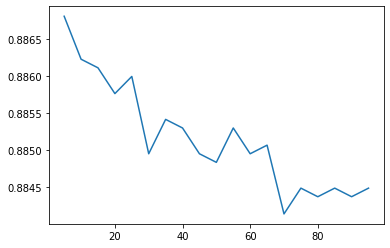

In [42]:
logistic_sel = LogisticRegression(max_iter=10000, random_state=42)
logistic_feature_score_lst = fs_score(logistic_sel, x_train, y_train)

In [43]:
print(logistic_feature_score_lst)
print(np.argmax(logistic_feature_score_lst))
print(np.max(logistic_feature_score_lst))

[0.88680463 0.88622525 0.88610924 0.88576168 0.88599317 0.88495063
 0.88541419 0.88529825 0.88495069 0.88483495 0.88529832 0.88495083
 0.88506664 0.88413977 0.88448733 0.88437145 0.88448746 0.88437166
 0.88448726]
0
0.8868046250639928


In [44]:
lr_sel_lst = print_feature(logistic_feature_score_lst, x_train, y_train)
print(lr_sel_lst)

['ExitRates' 'PageValues' 'Month_Nov']


In [45]:
lr_sel, lr_only_select = make_selected_model(logistic_feature_score_lst, logistic_sel, x_train)

In [46]:
x_train_selected_lr_only = lr_only_select.transform(x_train)
x_test_selected_lr_only = lr_only_select.transform(x_test)

In [47]:
lr_train_only = (logistic_sel.score(x_train_selected_lr_only, y_train))
lr_test_only = (logistic_sel.score(x_test_selected_lr_only, y_test))

In [48]:
lr_fs_score = make_score_df('LR_FS', y_test, logistic_sel.predict(x_test_selected_lr_only), lr_test_only, lr_train_only)

In [49]:
lr_fs_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,LR_FS,0.887035,0.883212,0.883212,0.356522,0.76779,0.486936,0.668338


Text(0.5, 15.0, 'Predicted label')

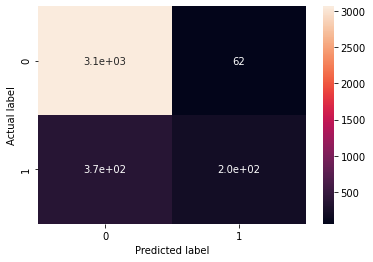

In [50]:
sns.heatmap(confusion_matrix(y_test, lr_sel.predict(x_test_selected_lr_only)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 2.4 with Feature Selection & Threshold

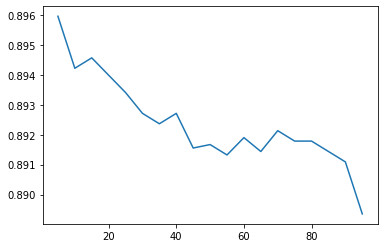

In [51]:
lr_fs_t_score_lst = np.array([])
logistic_fs = LogisticRegression(max_iter=10000, random_state=42)

for i in percent:   # 각 퍼센트마다
  skf = StratifiedKFold(n_splits=5)
  val_accuracy = np.array([])
  
  select = SelectPercentile(score_func=f_classif, percentile=i)  
  select.fit(x_train, y_train)
  x_train_selected_lr = select.transform(x_train)    # feature 선택해서 거른거

  for train_index, val_index in skf.split(x_train_selected_lr, y_train):    # train data를 validation set으로 나눠
    x_train_cv, x_val_cv = x_train_selected_lr[train_index], x_train_selected_lr[val_index]     
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    logistic_fs.fit(x_train_cv, y_train_cv)      # validation set의 train set으로  학습
    predict_proba = logistic_fs.predict_proba(x_val_cv)   # 확률 예측
    predict_proba = predict_proba[:,1]
    predict_y = np.where(predict_proba >= threshold_lst[np.argmax(threshold_score)], 1, 0)      # threshold를 기준으로 1, 0 분류

    TP, TN, FP, FN = cal_metrics(y_val_cv, predict_y) 
    val_accuracy = np.append(val_accuracy, (TP + TN) / len(predict_y))    # accuracy
  lr_fs_t_score_lst = np.append(lr_fs_t_score_lst, val_accuracy.mean())

plt.plot(percent, lr_fs_t_score_lst)

In [52]:
print(lr_fs_t_score_lst)
print(np.argmax(lr_fs_t_score_lst))
print(np.max(lr_fs_t_score_lst))

[0.89595746 0.89421954 0.89456737 0.89398786 0.89340842 0.8927133
 0.89236534 0.89271303 0.89155455 0.89167036 0.89132301 0.89190231
 0.89143875 0.892134   0.89178637 0.89178637 0.89143881 0.89109119
 0.8893532 ]
0
0.8959574637966561


In [53]:
print_feature(lr_fs_t_score_lst, x_train, y_train)

array(['ExitRates', 'PageValues', 'Month_Nov'], dtype='<U32')

In [54]:
lr_select = SelectPercentile(score_func=f_classif, percentile=percent[np.argmax(lr_fs_t_score_lst)])
lr_select.fit(x_train, y_train)

x_train_selected_lr = lr_select.transform(x_train)
x_test_selected_lr = lr_select.transform(x_test)

logistic_fs.fit(x_train_selected_lr, y_train)

predict_proba_lr = logistic_fs.predict_proba(x_test_selected_lr)   # 확률 예측
predict_proba_lr = predict_proba_lr[:,1]
predict_y_ls = np.where(predict_proba_lr >= threshold_lst[np.argmax(threshold_score)], 1, 0)      # threshold를 기준으로 1, 0 분류

TP, TN, FP, FN = cal_metrics(y_test, predict_y_ls) 

In [55]:
(TP + TN) / len(predict_y_ls)

0.8915923222492566

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3124
           1       0.71      0.51      0.60       575

    accuracy                           0.89      3699
   macro avg       0.81      0.74      0.77      3699
weighted avg       0.88      0.89      0.88      3699



Text(0.5, 15.0, 'Predicted label')

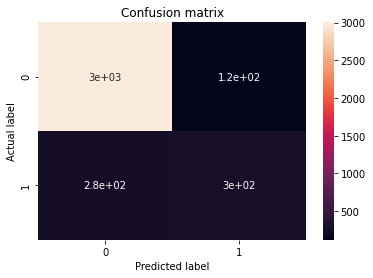

In [56]:
print(classification_report(y_test, predict_y_ls))

sns.heatmap(confusion_matrix(y_test, predict_y_ls), annot=True)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [57]:
predict_train_y_praoba = logistic_fs.predict_proba(x_train_selected_lr)
predict_train_y_praoba = predict_train_y_praoba[:,1]
predict_train_y = np.where(predict_train_y_praoba >= threshold_lst[np.argmax(threshold_score)], 1, 0)

TP_tr, TN_tr, FP_tr, FN_tr = cal_metrics(y_train, predict_train_y)

In [58]:
lr_th_fs_score_dict = {'model': ['LR_FS_threshold'], 'train': [(TP_tr + TN_tr)/len(y_train)], 'test': [(TP + TN)/len(y_test)],
                'accuracy': [(TP + TN)/len(y_test)], 'recall': [TP/(TP + FN)], 'precesion': [TP/(TP+FP)], 'f1 score': [(2*TP/(TP+FP)*TP/(TP + FN)) / ((TP/(TP+FP)) + TP/(TP + FN))] }

In [59]:
lr_th_fs_score = pd.DataFrame(lr_th_fs_score_dict)

In [60]:
lr_th_fs_score

,model,train,test,accuracy,recall,precesion,f1 score
0,LR_FS_threshold,0.896188,0.891592,0.891592,0.513043,0.709135,0.595358


## 3. Decision Tree

### 3.1 Default

In [61]:
dtclassifier = DecisionTreeClassifier(random_state=42)
dtclassifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [62]:
dot_data = StringIO()
export_graphviz(dtclassifier, feature_names=X.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [63]:
print(dtclassifier.score(x_train, y_train))
print(dtclassifier.score(x_test, y_test)) 

1.0
0.8526628818599622


In [64]:
dt_score = make_score_df('DT', y_test, dtclassifier.predict(x_test), dtclassifier.score(x_test, y_test), dtclassifier.score(x_train, y_train))

In [65]:
dt_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,DT,1.0,0.852663,0.852663,0.535652,0.525597,0.530577,0.723332


Text(0.5, 15.0, 'Predicted label')

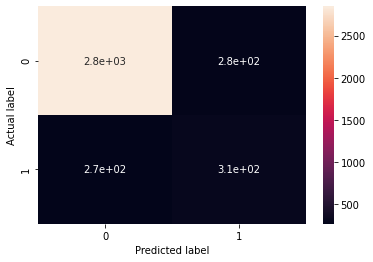

In [66]:
sns.heatmap(confusion_matrix(y_test, dtclassifier.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

그래프를 볼 수 있듯이 아주 복잡한 모델을 만든다. 또한 성능도 ZERO-R에 비해 뛰어난 정도도 아니다.
무엇보다도 train data set에 대한 score가 1인 반면에 test data set에 대한 score는 0.84이므로 overfitting 됐음을 알 수 있다.

### 3.2 with Pruning
아래 코드는 가장 괜찮은 maximum detph를 cross-validation을 통해 찾는 코드다.

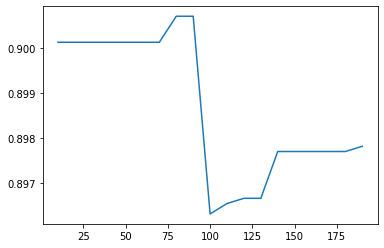

In [67]:
leaf_lst = np.arange(10, 200, 10)      # leaf list
dtprune_score = np.array([])

for i in leaf_lst:
  skf = StratifiedKFold(n_splits=5)
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(x_train, y_train):    # train data를 validation set으로 나눠
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]     
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    prune_classifier_val = DecisionTreeClassifier(max_leaf_nodes=10, min_samples_split=20, min_samples_leaf=i, random_state=42)
    prune_classifier_val.fit(x_train_cv, y_train_cv)
    val_accuracy = np.append(val_accuracy, prune_classifier_val.score(x_val_cv, y_val_cv))    # validation accuracy
  dtprune_score = np.append(dtprune_score, val_accuracy.mean())   # 하나의 fold에 대해 평균 accuracy

plt.plot(leaf_lst, dtprune_score)

In [68]:
print(dtprune_score)
print(leaf_lst[np.argmax(dtprune_score)])
print(np.max(dtprune_score))

[0.90012809 0.90012809 0.90012809 0.90012809 0.90012809 0.90012809
 0.90012809 0.90070746 0.90070746 0.89630448 0.89653623 0.89665211
 0.89665211 0.89769471 0.89769471 0.89769471 0.89769471 0.89769471
 0.89781059]
80
0.9007074606095944


In [69]:
prune_classifier = DecisionTreeClassifier(max_leaf_nodes=10, min_samples_split=20, min_samples_leaf=leaf_lst[np.argmax(dtprune_score)], random_state=42)
prune_classifier.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=80, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

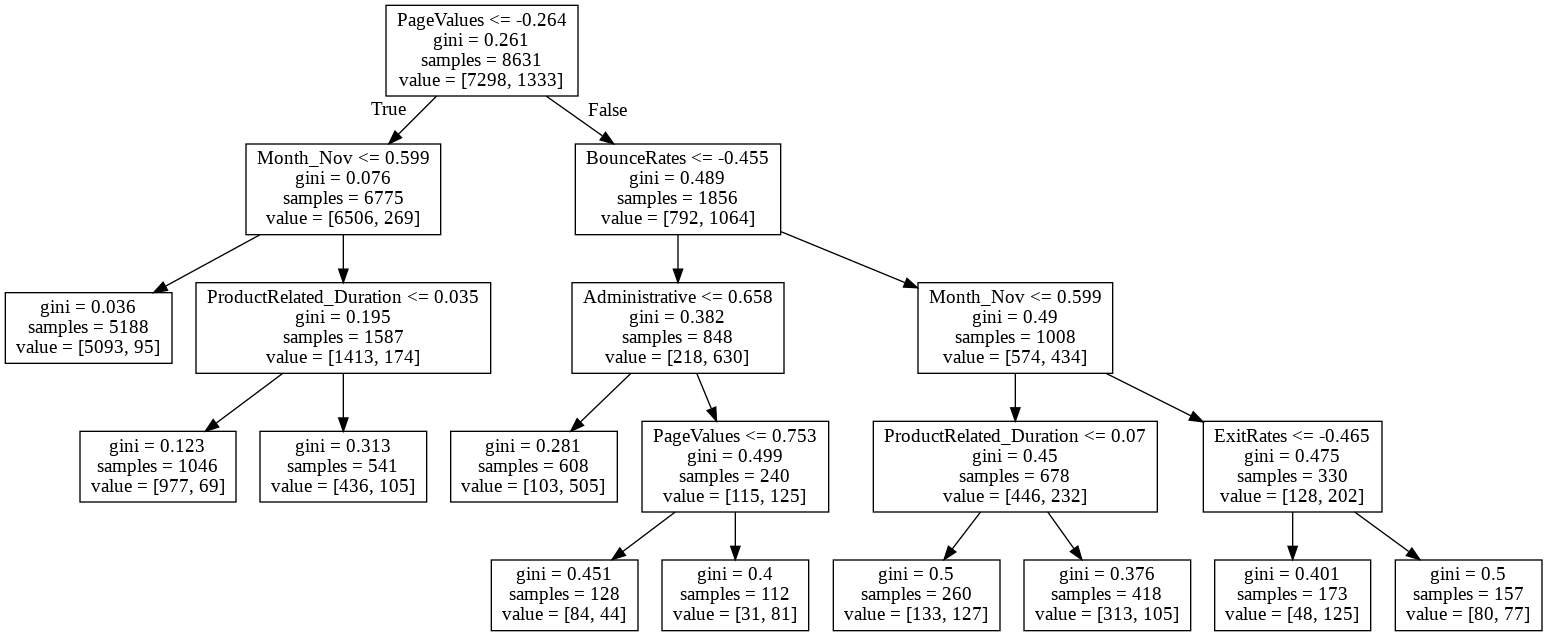

In [70]:
dot_data = StringIO()
export_graphviz(prune_classifier, feature_names=X.columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

In [71]:
print(prune_classifier.score(x_train, y_train))
print(prune_classifier.score(x_test, y_test))

0.9068474104970455
0.8972695323060287


In [72]:
dt_prune_score = make_score_df('DT_prune', y_test, prune_classifier.predict(x_test), prune_classifier.score(x_test, y_test), prune_classifier.score(x_train, y_train))

In [73]:
dt_prune_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,DT_prune,0.906847,0.89727,0.89727,0.490435,0.764228,0.597458,0.731293


Text(0.5, 15.0, 'Predicted label')

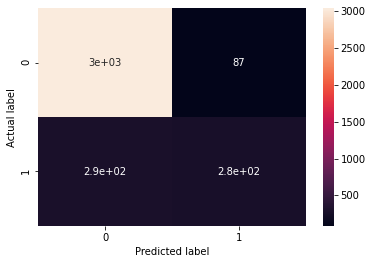

In [74]:
sns.heatmap(confusion_matrix(y_test, prune_classifier.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

prunging 즉, 가지치기를 했더니 overfitting문제도 해결돼고 accuracy도 0.89퍼센트로 높아졌다.

### 3.3 with Feature Selection

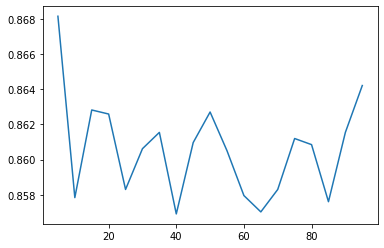

In [75]:
dtclassifier_sel = DecisionTreeClassifier(random_state=42)      # FS용 모델 만들기
dt_feature_score_lst = fs_score(dtclassifier_sel, x_train, y_train)

In [76]:
print(dt_feature_score_lst)
print(np.argmax(dt_feature_score_lst))
print(np.max(dt_feature_score_lst))

[0.86814985 0.85783866 0.86282088 0.86259034 0.8583023  0.86061979
 0.86154693 0.85691193 0.86096715 0.862705   0.86050318 0.85795467
 0.8570268  0.85830236 0.86119863 0.86085107 0.85760705 0.86154626
 0.86421071]
0
0.8681498469203925


In [77]:
dt_lst = print_feature((dt_feature_score_lst), x_train, y_train)
print(dt_lst)

['ExitRates' 'PageValues' 'Month_Nov']


In [78]:
dtclassifier_sel, dt_only_select = make_selected_model(dt_feature_score_lst, dtclassifier_sel, x_train)

In [79]:
x_train_selected_dt_only = dt_only_select.transform(x_train)
x_test_selected_dt_only = dt_only_select.transform(x_test)

In [80]:
dt_train_only = (dtclassifier_sel.score(x_train_selected_dt_only, y_train))
dt_test_only = (dtclassifier_sel.score(x_test_selected_dt_only, y_test))

In [81]:
dot_data = StringIO()
export_graphviz(dtclassifier_sel, feature_names=dt_lst, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [82]:
dt_fs_score = make_score_df('DT_FS', y_test, dtclassifier_sel.predict(x_test_selected_dt_only), dt_test_only, dt_train_only)

In [83]:
dt_fs_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,DT_FS,0.985865,0.866991,0.866991,0.535652,0.577861,0.555957,0.731815


Text(0.5, 15.0, 'Predicted label')

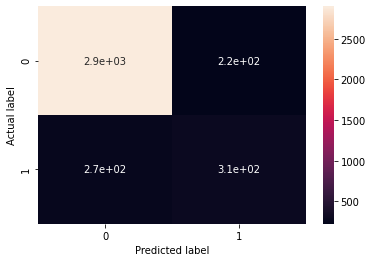

In [84]:
sns.heatmap(confusion_matrix(y_test, dtclassifier_sel.predict(x_test_selected_dt_only)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

그래프가 여전히 복잡하고 모델은 overfit된 상태이다. 또한 test data set에 대한 score도 0.86정도로 pruning을 했을 때보다 낮다. 그래프도 여전히 너무 깊고 복잡하다.

### 3.4 with Feature Selection & Pruning

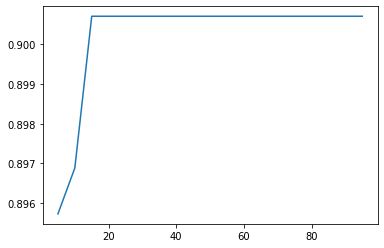

In [85]:
prune_classifier_sel = DecisionTreeClassifier(max_leaf_nodes=10, min_samples_split=20, min_samples_leaf=leaf_lst[np.argmax(dtprune_score)], random_state=42)
dt_prune_fs_score_lst = fs_score(prune_classifier_sel, x_train, y_train)    # 적절한 selection찾기

In [86]:
print(dt_prune_fs_score_lst)
print(np.argmax(dt_prune_fs_score_lst))
print(np.max(dt_prune_fs_score_lst))

[0.89572632 0.89688366 0.90070746 0.90070746 0.90070746 0.90070746
 0.90070746 0.90070746 0.90070746 0.90070746 0.90070746 0.90070746
 0.90070746 0.90070746 0.90070746 0.90070746 0.90070746 0.90070746
 0.90070746]
2
0.9007074606095944


In [87]:
print_feature(dt_prune_fs_score_lst, x_train, y_train)

array(['Administrative', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov',
       'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor'],
      dtype='<U32')

In [88]:
prune_classifier_sel, dt_select = make_selected_model(dt_prune_fs_score_lst, prune_classifier_sel, x_train)    # feature 적용해서

In [89]:
x_train_selected_dt = dt_select.transform(x_train)
x_test_selected_dt = dt_select.transform(x_test)

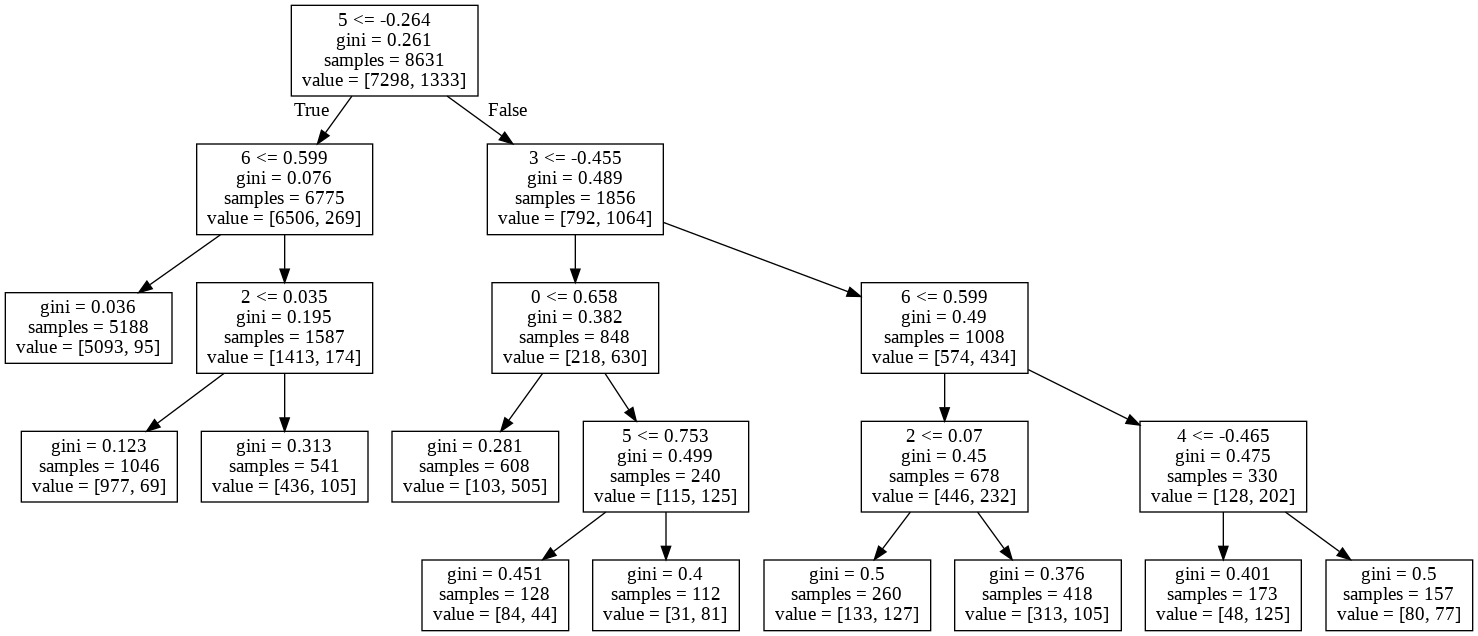

In [90]:
dot_data = StringIO()
export_graphviz(prune_classifier_sel, feature_names=pd.DataFrame(x_train_selected_dt).columns, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/tree.png')
Image(graph.create_png())

In [91]:
dt_train = (prune_classifier_sel.score(x_train_selected_dt, y_train))
dt_test = (prune_classifier_sel.score(x_test_selected_dt, y_test))

In [92]:
dt_prune_fs_score = make_score_df('DT_PRUNE_FS', y_test, prune_classifier_sel.predict(x_test_selected_dt), dt_test, dt_train)

In [93]:
dt_prune_fs_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,DT_PRUNE_FS,0.906847,0.89727,0.89727,0.490435,0.764228,0.597458,0.731293


Text(0.5, 15.0, 'Predicted label')

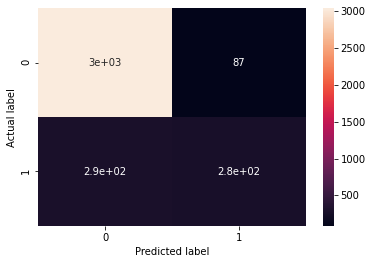

In [94]:
sns.heatmap(confusion_matrix(y_test, prune_classifier_sel.predict(x_test_selected_dt)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

pruning과 feature selection을 같이 했을 때와 pruning만을 했을 때의 성능은 거의 유사하다. 이는 Decision Tree의 모델 특성과 관련이 있는 듯 하다.

Decision Tree는 feature를 골라서 그 feature의 값에 따라 데이터들을 분류하는데, pruning을 하면 feature들도 어느정도 잘려나가기 때문에 pruning을 적용한 Decision Tree model에 feature selection을 적용하든 안 하든 큰 차이가 없는 것 같다.

하지만, pruning을 안 하고, feature selection만 적용하여 학습 한다면 Decision Tree가 train data set에 대해서 주어진 feature들에 대해 overfit될 수 있다.

## 4. Perceptron

### 4.1 Default

In [95]:
perceptron = Perceptron(random_state=42)
perceptron.fit(x_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [96]:
print(perceptron.score(x_train, y_train))
print(perceptron.score(x_test, y_test))

0.8478739427644537
0.8434712084347121


In [97]:
perceptron_score = make_score_df('Perceptron', y_test, perceptron.predict(x_test), perceptron.score(x_test, y_test), perceptron.score(x_train, y_train))

In [98]:
perceptron_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,Perceptron,0.847874,0.843471,0.843471,0.373913,0.495392,0.426165,0.651905


아무런 파라미터를 조절하지 않고 기본 값으로 만들면 ZERO-R과 성능이 비슷한 모델이 만들어진다.

Text(0.5, 15.0, 'Predicted label')

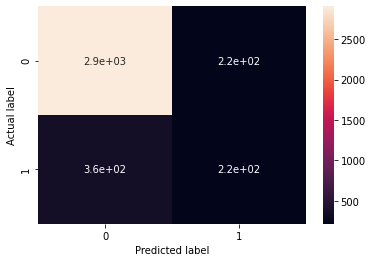

In [99]:
sns.heatmap(confusion_matrix(y_test, perceptron.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 4.2 with Penalty
cross-validation을 통해 가장 좋은 penalty parameter를 찾는다.

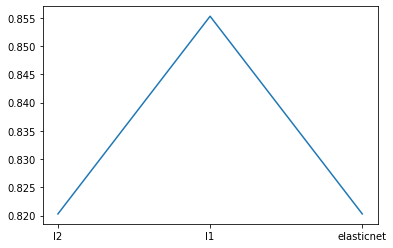

In [100]:
penalty_lst = ['l2', 'l1', 'elasticnet']      # penalty list
score = []

for i in penalty_lst:
  skf = StratifiedKFold(n_splits=5)
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(x_train, y_train):    # train data를 validation set으로 나눠
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]     
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    perceptron_val = Perceptron(random_state=42, penalty=i)
    perceptron_val.fit(x_train_cv, y_train_cv)
    val_accuracy = np.append(val_accuracy, perceptron_val.score(x_val_cv, y_val_cv))    # validation accuracy
  score.append(val_accuracy.mean())   # 하나의 fold에 대해 평균 accuracy

plt.plot(penalty_lst, score)

In [101]:
print(score)
print(penalty_lst[np.argmax(score)])
print(np.max(score))

[0.8202978929831636, 0.8552900192632722, 0.8202978929831636]
l1
0.8552900192632722


In [102]:
perceptron_par = Perceptron(random_state=42, penalty=penalty_lst[np.argmax(score)])
perceptron_par.fit(x_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l1', random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
pertrain = perceptron_par.score(x_train, y_train)
pertest = perceptron_par.score(x_test, y_test)

In [104]:
perceptron_penalty_score = make_score_df('Perceptron_penalty', y_test, perceptron_par.predict(x_test), pertest, pertrain)

In [105]:
perceptron_penalty_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,Perceptron_penalty,0.810682,0.802649,0.802649,0.636522,0.412627,0.500684,0.734874


Text(0.5, 15.0, 'Predicted label')

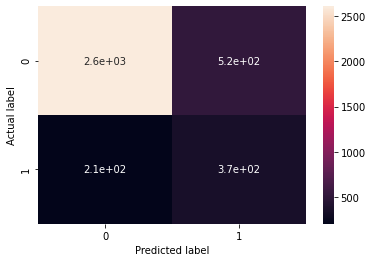

In [106]:
sns.heatmap(confusion_matrix(y_test, perceptron_par.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

cross-validation을 통해서 penalty를 l1으로 결정했지만 실제 성능은 더 떨어졌다.

### 4.3 with Feature Selection

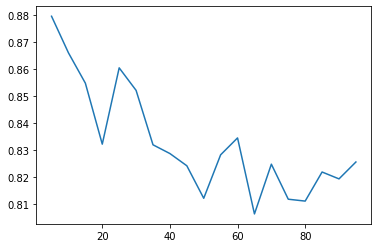

In [107]:
perceptron_sel = Perceptron(random_state=42)
perceptron_feature_score_lst = fs_score(perceptron_sel, x_train, y_train)

In [108]:
print(perceptron_feature_score_lst)
print(np.argmax(perceptron_feature_score_lst))
print(np.max(perceptron_feature_score_lst))

[0.87962012 0.86606215 0.85482605 0.8322381  0.8605013  0.85215979
 0.8319981  0.82875474 0.82423401 0.8121886  0.82829111 0.83454815
 0.80639331 0.82481869 0.81183869 0.81114304 0.82191679 0.81937063
 0.82562794]
0
0.8796201156601479


In [109]:
perceptron_lst = print_feature(perceptron_feature_score_lst, x_train, y_train)
print(perceptron_lst)

['ExitRates' 'PageValues' 'Month_Nov']


In [110]:
perceptron_sel, pct_select_fs = make_selected_model(perceptron_feature_score_lst, perceptron_sel, x_train)

In [111]:
x_train_selected_pct_fs = pct_select_fs.transform(x_train)
x_test_selected_pct_fs = pct_select_fs.transform(x_test)

In [112]:
pct_train_sel_fs = (perceptron_sel.score(x_train_selected_pct_fs, y_train))
pct_test_sel_fs = (perceptron_sel.score(x_test_selected_pct_fs, y_test))

In [113]:
perceptron_fs_score = make_score_df('Perceptron_FS', y_test, perceptron_sel.predict(x_test_selected_pct_fs), pct_test_sel_fs, pct_train_sel_fs)

In [114]:
perceptron_fs_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,Perceptron_FS,0.886572,0.889159,0.889159,0.525217,0.687927,0.595661,0.740682


Text(0.5, 15.0, 'Predicted label')

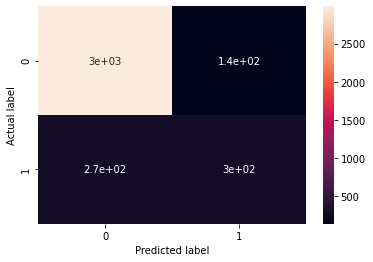

In [115]:
sns.heatmap(confusion_matrix(y_test, perceptron_sel.predict(x_test_selected_pct_fs)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 4.4 with Feature Selection & Penalty

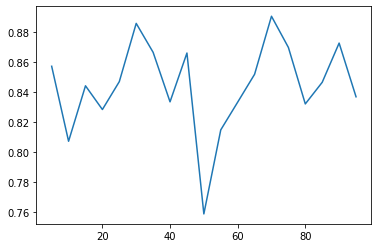

In [116]:
perceprton_par_sel = Perceptron(random_state=42, penalty=penalty_lst[np.argmax(score)])
perceptron_penalty_fs_score_lst = fs_score(perceprton_par_sel, x_train, y_train)

In [117]:
print(perceptron_penalty_fs_score_lst)
print(np.argmax(perceptron_penalty_fs_score_lst))
print(np.max(perceptron_penalty_fs_score_lst))

[0.85703841 0.80719719 0.84404848 0.82829051 0.84682787 0.88553168
 0.86629585 0.83340074 0.86583544 0.75890663 0.8147508  0.83317671
 0.85169542 0.89028054 0.86954155 0.83200729 0.84637591 0.8724399
 0.83675004]
13
0.890280535238503


In [118]:
print_feature(perceptron_penalty_fs_score_lst, x_train, y_train)

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay', 'Weekend', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'VisitorType_New_Visitor',
       'VisitorType_Returning_Visitor', 'OperatingSystems_2',
       'OperatingSystems_3', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Region_1', 'Region_3', 'Region_8', 'TrafficType_1',
       'TrafficType_2', 'TrafficType_3', 'TrafficType_5', 'TrafficType_6',
       'TrafficType_8', 'TrafficType_10', 'TrafficType_11',
       'TrafficType_13'], dtype='<U32')

In [119]:
perceprton_par_sel, pct_select = make_selected_model(perceptron_penalty_fs_score_lst, perceprton_par_sel, x_train)

In [120]:
x_train_selected_pct = pct_select.transform(x_train)
x_test_selected_pct = pct_select.transform(x_test)

In [121]:
pct_train_sel = perceprton_par_sel.score(x_train_selected_pct, y_train)
pct_test_sel = perceprton_par_sel.score(x_test_selected_pct, y_test)

In [122]:
perceptron_par_sel_score = make_score_df('Perceptron_FS_penalty', y_test, perceprton_par_sel.predict(x_test_selected_pct), pct_test_sel, pct_train_sel)

In [123]:
perceptron_par_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,Perceptron_FS_penalty,0.819835,0.825899,0.825899,0.488696,0.445325,0.466003,0.68833


Text(0.5, 15.0, 'Predicted label')

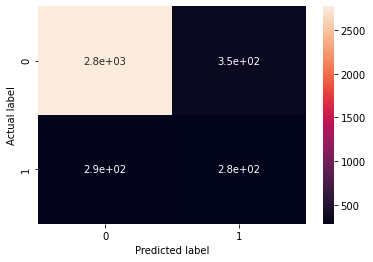

In [124]:
sns.heatmap(confusion_matrix(y_test, perceprton_par_sel.predict(x_test_selected_pct)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 5. MLP

### 5.1 Default

In [125]:
mlp = MLPClassifier(random_state=42, max_iter=1000)  
mlp.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [126]:
mlptrain = (mlp.score(x_train, y_train))
mlptest = (mlp.score(x_test, y_test))

In [127]:
mlp_score = make_score_df('MLP', y_test, mlp.predict(x_test), mlptest, mlptrain)

In [128]:
mlp_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,MLP,0.997103,0.867532,0.867532,0.551304,0.577413,0.564057,0.73852


Text(0.5, 15.0, 'Predicted label')

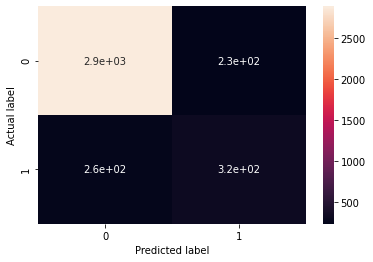

In [129]:
sns.heatmap(confusion_matrix(y_test, mlp.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

default MLP 모델을 만들었을 때, 만점에 가까운 train data set의 score에 비해 test data set의 score가 낮다. 즉, overfitting이 됐음을 알 수 있다.

### 5.2 with Reducing Hidden Layer

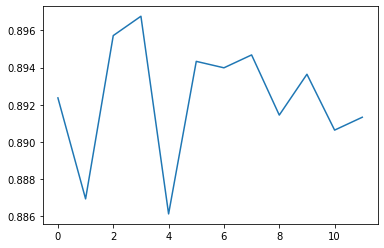

In [130]:
hidden_lst = [[2, 2], [2, 3], [2, 5], [2, 7], [3, 2], [3, 3], [3, 5], [3, 7], [5, 2], [5, 3], [5, 5], [5, 7]]
hidden_index = np.arange(len(hidden_lst))
score = []

for i in hidden_lst:
  skf = StratifiedKFold(n_splits=5)
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(x_train, y_train):    # train data를 validation set으로 나눠
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]     
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    mlp_val = MLPClassifier(random_state=42, hidden_layer_sizes=(i[0], i[1]), max_iter=1000)
    mlp_val.fit(x_train_cv, y_train_cv)
    val_accuracy = np.append(val_accuracy, mlp_val.score(x_val_cv, y_val_cv))    # validation accuracy
  score.append(val_accuracy.mean())   # 하나의 fold에 대해 평균 accuracy

plt.plot(hidden_index, score)

In [131]:
print(score)
print(hidden_lst[np.argmax(score)])
print(np.max(score))

[0.8923652090947336, 0.88691989605482, 0.8957250431259774, 0.8967679839184219, 0.8861089733568349, 0.89433474615221, 0.893987389970887, 0.8946822365256063, 0.8914379418693358, 0.8936400337895641, 0.8906277572277528, 0.8913225366864352]
[2, 7]
0.8967679839184219


In [132]:
mlp_par = MLPClassifier(random_state=42, hidden_layer_sizes=(hidden_lst[np.argmax(score)][0], hidden_lst[np.argmax(score)][1]), max_iter=1000)
mlp_par.fit(x_test, y_test)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(2, 7), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [133]:
mlppartrain = (mlp_par.score(x_train, y_train))
mlppartest = (mlp_par.score(x_test, y_test))

In [134]:
mlp_par_score = make_score_df('MLP_hidden', y_test, mlp_par.predict(x_test), mlppartest, mlppartrain)

In [135]:
mlp_par_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,MLP_hidden,0.888078,0.902947,0.902947,0.725217,0.674757,0.699078,0.830438


Text(0.5, 15.0, 'Predicted label')

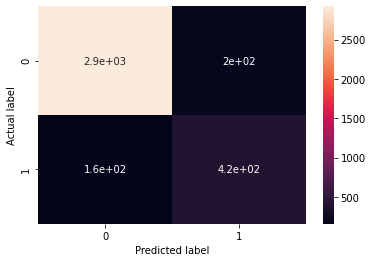

In [136]:
sns.heatmap(confusion_matrix(y_test, mlp_par.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

파라미터를 조절하지 않은 default 모델의 경우 hidden_layer_sizes=(100,)이다.cross-validation을 통해서 hidden layer 갯수의 후보 중 위에서는 (5, 3)를 선택했다. 그 결과 default 모델과 다르게 overfitting도 해결할 수 있고, 성능도 좋았다.

즉, 주어진 데이터 셋에 대해서 hidden layer가 100장일 필요가 없다고 해석할 수 있다. 다시 말해서 주어진 데이터 셋에 비해 모델이 너무 복잡했기 때문에 overfitting이 발생했다고 볼 수 있다. 따라서, 파라미터를 조절해서 hidden layer 수와 hidden unit 수를 변경하면 더 괜찮은 성능의 모델을 얻을 수 있다.

 

### 5.3 with Feature Selection

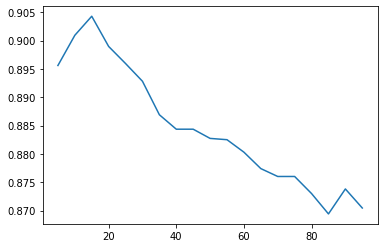

In [137]:
mlp_sel = MLPClassifier(random_state=42, max_iter=1000)
mlp_feature_score_lst = fs_score(mlp_sel, x_train, y_train)

In [138]:
print(mlp_feature_score_lst)
print(np.argmax(mlp_feature_score_lst))
print(np.max(mlp_feature_score_lst))

[0.89560924 0.90093861 0.90429931 0.89896961 0.89595706 0.8928281
 0.8869199  0.88437018 0.88436964 0.88274726 0.88251726 0.8803153
 0.87741816 0.8760288  0.87602887 0.87301558 0.8694236  0.87382711
 0.87046775]
2
0.9042993127352974


In [139]:
mlp_lst = print_feature(mlp_feature_score_lst, x_train, y_train)
print(mlp_lst)

['Administrative' 'ProductRelated' 'ProductRelated_Duration' 'BounceRates'
 'ExitRates' 'PageValues' 'Month_Nov' 'VisitorType_New_Visitor'
 'VisitorType_Returning_Visitor']


In [140]:
mlp_sel, mlp_sel_select = make_selected_model(mlp_feature_score_lst, mlp_sel, x_train)

In [141]:
x_train_selected_mlp_sel = mlp_sel_select.transform(x_train)
x_test_selected_mlp_sel = mlp_sel_select.transform(x_test)

In [142]:
mlp_train_sel = mlp_sel.score(x_train_selected_mlp_sel, y_train)
mlp_test_sel = mlp_sel.score(x_test_selected_mlp_sel, y_test)

In [143]:
mlp_sel_score = make_score_df('MLP_FS', y_test, mlp_sel.predict(x_test_selected_mlp_sel), mlp_test_sel, mlp_train_sel)

In [144]:
mlp_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,MLP_FS,0.91264,0.898351,0.898351,0.584348,0.710359,0.641221,0.770247


Text(0.5, 15.0, 'Predicted label')

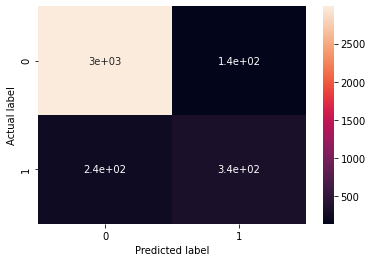

In [145]:
sns.heatmap(confusion_matrix(y_test, mlp_sel.predict(x_test_selected_mlp_sel)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

default 모델(파라미터를 변경하지 않은 모델)에 대해서 feature selection을 적용하면 기존에 나타났던 overfitting을 해결할 수 있다. hidden layer가 똑같이 100개이지만 거의 60개였던 feature의 수가 9개로 줄었기 때문에 더 단순한 모델이 만들어 졌다. 결과적으로는 overfitting도 해결하고 괜찮은 성능을 가지는 모델을 얻을 수 있다.

### 5.4 with Feature Selection & Hidden Layer

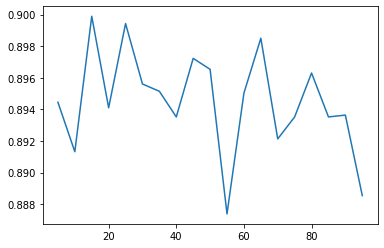

In [146]:
mlp_par_sel = MLPClassifier(random_state=42, hidden_layer_sizes=(hidden_lst[np.argmax(score)][0], hidden_lst[np.argmax(score)][1]), max_iter=1000)
mlp_par_feature_score_lst = fs_score(mlp_par_sel, x_train, y_train)

In [147]:
print(mlp_par_feature_score_lst)
print(np.argmax(mlp_par_feature_score_lst))
print(np.max(mlp_par_feature_score_lst))

[0.89445116 0.89132193 0.89989674 0.89410306 0.89943364 0.89560937
 0.89514567 0.89352396 0.89723142 0.89653617 0.88738467 0.89503006
 0.89850611 0.89213393 0.89352389 0.89630435 0.89352423 0.8936397
 0.88854214]
2
0.8998967391997187


In [148]:
mlp_par_lst = print_feature(mlp_par_feature_score_lst, x_train, y_train)
print(mlp_par_lst)

['Administrative' 'ProductRelated' 'ProductRelated_Duration' 'BounceRates'
 'ExitRates' 'PageValues' 'Month_Nov' 'VisitorType_New_Visitor'
 'VisitorType_Returning_Visitor']


In [149]:
mlp_par_sel, mlp_par_sel_select = make_selected_model(mlp_par_feature_score_lst, mlp_par_sel, x_train)

In [150]:
x_train_selected_mlp_par_sel = mlp_par_sel_select.transform(x_train)
x_test_selected_mlp_par_sel = mlp_par_sel_select.transform(x_test)

In [151]:
mlp_train_par_sel = mlp_par_sel.score(x_train_selected_mlp_par_sel, y_train)
mlp_test_par_sel = mlp_par_sel.score(x_test_selected_mlp_par_sel, y_test)

In [152]:
mlp_par_sel_score = make_score_df('MLP_FS_hidden', y_test, mlp_par_sel.predict(x_test_selected_mlp_par_sel), mlp_test_par_sel, mlp_train_par_sel)

In [153]:
mlp_par_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,MLP_FS_hidden,0.900938,0.889159,0.889159,0.554783,0.674419,0.608779,0.752743


Text(0.5, 15.0, 'Predicted label')

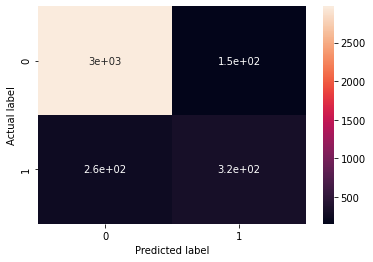

In [154]:
sns.heatmap(confusion_matrix(y_test, mlp_par_sel.predict(x_test_selected_mlp_par_sel)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 6. KNN


### 6.1 Default

In [155]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [156]:
knn.score(x_test, y_test)

0.8569883752365505

In [157]:
knn_score = make_score_df('KNN', y_test, knn.predict(x_test), knn.score(x_test, y_test), knn.score(x_train, y_train))

In [158]:
knn_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,KNN,0.879736,0.856988,0.856988,0.196522,0.627778,0.299338,0.587537


Text(0.5, 15.0, 'Predicted label')

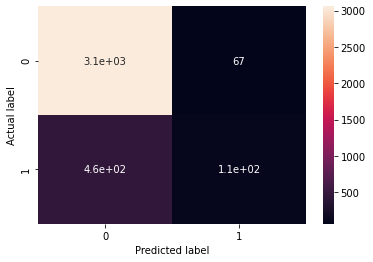

In [159]:
sns.heatmap(confusion_matrix(y_test, knn.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

knn에서 k가 5인 경우 성능은 ZERO-R보다 약간 나은 정도다.

### 6.2 with Selecting K

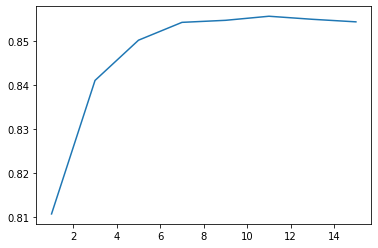

In [160]:
n_neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15]
k_score = np.array([])

for k in n_neighbors_list:
  skf = StratifiedKFold(n_splits=5)   # 5 fold     
  val_accuracy = np.array([])          
  for train_index, val_index in skf.split(x_train, y_train): 
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    knnk = KNeighborsClassifier(n_neighbors=k)
    knnk.fit(x_train_cv, y_train_cv)
    val_accuracy = np.append(val_accuracy, knnk.score(x_val_cv, y_val_cv))
  k_score = np.append(k_score, val_accuracy.mean())

plt.plot(n_neighbors_list, k_score)

In [161]:
print(n_neighbors_list[np.argmax(k_score)])

11


In [162]:
knnk = KNeighborsClassifier(n_neighbors=n_neighbors_list[np.argmax(k_score)])
knnk.fit(x_train, y_train)
knnk.score(x_test, y_test)

0.857529061908624

In [163]:
knn_par_score = make_score_df('KNN_k', y_test, knnk.predict(x_test), knnk.score(x_test, y_test), knnk.score(x_train, y_train))

In [164]:
knn_par_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,KNN_k,0.864674,0.857529,0.857529,0.121739,0.76087,0.209895,0.557348


Text(0.5, 15.0, 'Predicted label')

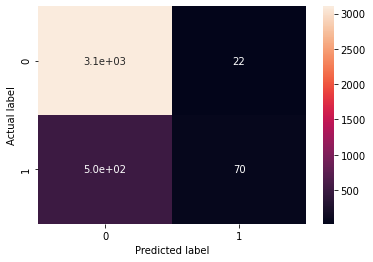

In [165]:
sns.heatmap(confusion_matrix(y_test, knnk.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

k값을 조절해봐도 성능이 크게 좋아지지는 않는다.

### 6.3 with Feature Selection

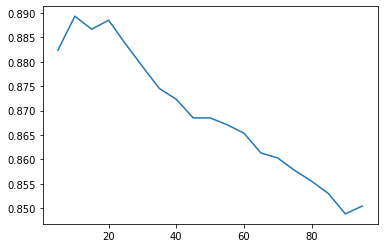

In [166]:
knn_sel = KNeighborsClassifier()
knn_feature_score_lst = fs_score(knn_sel, x_train, y_train)

In [167]:
print(knn_feature_score_lst)
print(np.argmax(knn_feature_score_lst))
print(np.max(knn_feature_score_lst))

[0.88240205 0.88935374 0.88668862 0.88854141 0.88367533 0.87904061
 0.87452209 0.87232067 0.86849754 0.86849767 0.86710717 0.86536952
 0.86131424 0.86027109 0.85772232 0.85552117 0.85297199 0.84880036
 0.85042193]
1
0.8893537376853612


In [168]:
knn_lst = print_feature(knn_feature_score_lst, x_train, y_train)
print(knn_lst)

['ProductRelated' 'ProductRelated_Duration' 'BounceRates' 'ExitRates'
 'PageValues' 'Month_Nov']


In [169]:
knn_sel, knn_sel_select = make_selected_model(knn_feature_score_lst, knn_sel, x_train)

In [170]:
x_train_selected_knn_sel = knn_sel_select.transform(x_train) 
x_test_selected_knn_sel = knn_sel_select.transform(x_test)

In [171]:
knn_train_sel = knn_sel.score(x_train_selected_knn_sel, y_train)
knn_test_sel = knn_sel.score(x_test_selected_knn_sel, y_test)

In [172]:
knn_sel_score = make_score_df('KNN_FS', y_test, knn_sel.predict(x_test_selected_knn_sel), knn_test_sel, knn_train_sel)

In [173]:
knn_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,KNN_FS,0.918781,0.891052,0.891052,0.546087,0.688596,0.609117,0.750316


Text(0.5, 15.0, 'Predicted label')

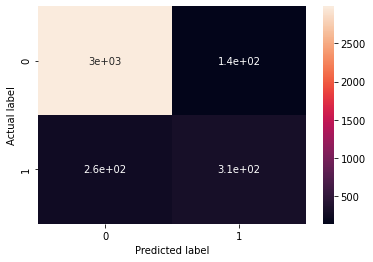

In [174]:
sns.heatmap(confusion_matrix(y_test, knn_sel.predict(x_test_selected_knn_sel)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

k를 그대로 5로 두고, feature selection을 적용한 결과 3-4퍼센트 정도 정확도가 증가했음을 알 수 있다.

knn은 데이터들 간의 거리를 계산해서 가장 가까운 k개의 data의 label을 뽑아서 다수결 원칙에 따라 최종적으로 label이 결정된다. 모든 feature를 선택한 것보다 일부 feature만 선택한 것이 더 좋은 성능을 보이는 것은, 선택된 feature들이 label값에 따라 비슷한 방향이라는 것이고, 선택되지 않은 feature들은 label의 영향을 덜 받는다고 해석 할 수 있다.

이 때 선택한 feature들은 'ExitRates', 'PageValues', 'Month_Nov'이다.

### 6.4 with Feature Selection & K

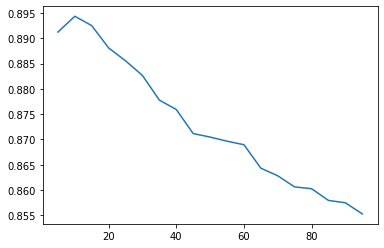

In [175]:
knn_par_sel = KNeighborsClassifier(n_neighbors=n_neighbors_list[np.argmax(k_score)])
knn_par_sel_feature_score_lst = fs_score(knn_par_sel, x_train, y_train)

In [176]:
print(knn_par_sel_feature_score_lst)
print(np.argmax(knn_par_sel_feature_score_lst))
print(np.max(knn_par_sel_feature_score_lst))

[0.89120774 0.89433528 0.89248155 0.88807844 0.88552946 0.88263306
 0.87776639 0.87591246 0.87116246 0.87046734 0.86965656 0.86896117
 0.86432658 0.86282027 0.86061885 0.8602713  0.8579542  0.85749037
 0.85528921]
1
0.8943352829205026


In [177]:
print_feature(knn_par_sel_feature_score_lst, x_train, y_train)

array(['ProductRelated', 'ProductRelated_Duration', 'BounceRates',
       'ExitRates', 'PageValues', 'Month_Nov'], dtype='<U32')

In [178]:
knn_par_sel, knn_par_sel_select = make_selected_model(k_score, knn_par_sel, x_train)

In [179]:
x_train_selected_knn_par_sel = knn_par_sel_select.transform(x_train) 
x_test_selected_knn_par_sel = knn_par_sel_select.transform(x_test)

In [180]:
knn_train_par_sel = knn_par_sel.score(x_train_selected_knn_par_sel, y_train)
knn_test_par_sel = knn_par_sel.score(x_test_selected_knn_par_sel, y_test)

In [181]:
knn_par_sel_score = make_score_df('KNN_FS_k', y_test, knn_par_sel.predict(x_test_selected_knn_par_sel), knn_test_par_sel, knn_train_par_sel)

In [182]:
knn_par_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,KNN_FS_k,0.893987,0.878886,0.878886,0.361739,0.719723,0.481481,0.667905


Text(0.5, 15.0, 'Predicted label')

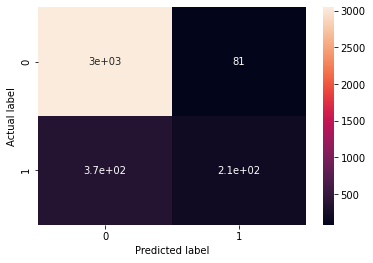

In [183]:
sns.heatmap(confusion_matrix(y_test, knn_par_sel.predict(x_test_selected_knn_par_sel)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## 7. Random Forest


### 7.1 Default

In [184]:
forest = RandomForestClassifier(random_state=42)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [185]:
print(forest.score(x_train, y_train))
print(forest.score(x_test, y_test))

1.0
0.895647472289808


In [186]:
rf_score = make_score_df('RF', y_test, forest.predict(x_test), forest.score(x_test, y_test), forest.score(x_train, y_train))

In [187]:
rf_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,RF,1.0,0.895647,0.895647,0.506087,0.740458,0.60124,0.736718


Text(0.5, 15.0, 'Predicted label')

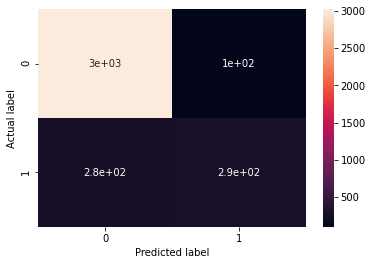

In [188]:
sns.heatmap(confusion_matrix(y_test, forest.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 7.2 with Pruning
가지치기 할 때 적절한 min_samples_leaf는 cross-validation을 통해 구한다.

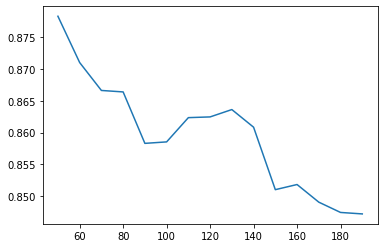

In [189]:
leaf_lst = np.arange(50, 200, 10)
leaf_score = np.array([])

for i in leaf_lst:
  forest_leaf = RandomForestClassifier(random_state=42, n_estimators=10, min_samples_leaf=i)

  leaf_score = np.append(leaf_score, cross_val_score(forest_leaf, x_train, y_train, cv=5).mean())

plt.plot(leaf_lst, leaf_score)

In [190]:
print(leaf_score)
print(np.argmax(leaf_score))
print(np.max(leaf_score))

[0.87834509 0.87104611 0.86664441 0.86641273 0.85830236 0.85853391
 0.86235805 0.86247278 0.86363153 0.86085013 0.85100245 0.85181297
 0.84903224 0.84741053 0.84717871]
0
0.8783450896772077


In [191]:
forest_leaf = RandomForestClassifier(random_state=42, n_estimators=10, min_samples_leaf=leaf_lst[np.argmax(leaf_score)])
forest_leaf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [192]:
forest_leaf_score = make_score_df('RF_leaf', y_test, forest_leaf.predict(x_test), forest_leaf.score(x_test, y_test), forest_leaf.score(x_train, y_train))

In [193]:
forest_leaf_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,RF_leaf,0.891322,0.877264,0.877264,0.304348,0.764192,0.435323,0.643531


Text(0.5, 15.0, 'Predicted label')

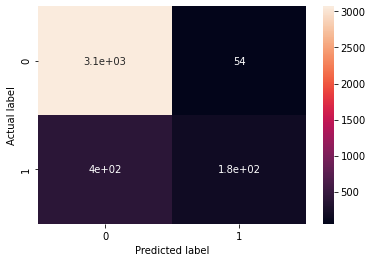

In [194]:
sns.heatmap(confusion_matrix(y_test, forest_leaf.predict(x_test)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 7.3 with Feature Selection


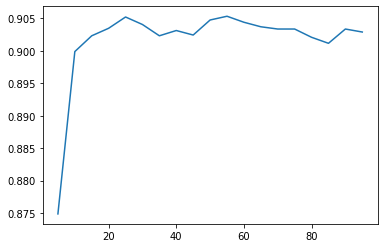

In [195]:
forest_sel = RandomForestClassifier(random_state=42)
forest_feature_score_lst = fs_score(forest_sel, x_train, y_train)

In [196]:
print(forest_feature_score_lst)
print(np.argmax(forest_feature_score_lst))
print(np.max(forest_feature_score_lst))

[0.87487153 0.899896   0.90232971 0.90348886 0.90522638 0.90406776
 0.90233011 0.90314117 0.90244525 0.90476301 0.90534225 0.90441566
 0.90372007 0.90337211 0.90337245 0.90209803 0.90117096 0.90337245
 0.90290908]
10
0.9053422535277418


In [197]:
rf_lst = print_feature(forest_feature_score_lst, x_train, y_train)
print(rf_lst)

['Administrative' 'Administrative_Duration' 'Informational'
 'Informational_Duration' 'ProductRelated' 'ProductRelated_Duration'
 'BounceRates' 'ExitRates' 'PageValues' 'SpecialDay' 'Weekend' 'Month_Dec'
 'Month_Feb' 'Month_June' 'Month_Mar' 'Month_May' 'Month_Nov' 'Month_Oct'
 'Month_Sep' 'VisitorType_New_Visitor' 'VisitorType_Returning_Visitor'
 'OperatingSystems_2' 'OperatingSystems_3' 'Browser_3' 'TrafficType_1'
 'TrafficType_2' 'TrafficType_3' 'TrafficType_5' 'TrafficType_8'
 'TrafficType_10' 'TrafficType_13']


In [198]:
forest_sel, forest_sel_select = make_selected_model(forest_feature_score_lst, forest_sel, x_train)

In [199]:
x_train_selected_rf_sel = forest_sel_select.transform(x_train)
x_test_selected_rf_sel = forest_sel_select.transform(x_test)

In [200]:
rf_train_sel = forest_sel.score(x_train_selected_rf_sel, y_train)
rf_test_sel = forest_sel.score(x_test_selected_rf_sel, y_test)

In [201]:
forest_sel_score = make_score_df('RF_FS', y_test, forest_sel.predict(x_test_selected_rf_sel), rf_test_sel, rf_train_sel)

In [202]:
forest_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,RF_FS,1.0,0.901054,0.901054,0.544348,0.7506,0.631048,0.755529


Text(0.5, 15.0, 'Predicted label')

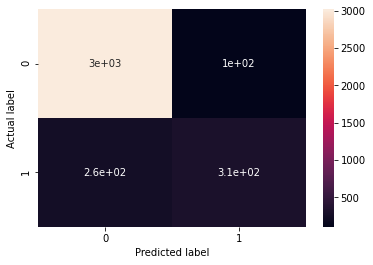

In [203]:
sns.heatmap(confusion_matrix(y_test, forest_sel.predict(x_test_selected_rf_sel)), annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### 7.4 with Feature Selection & Pruning

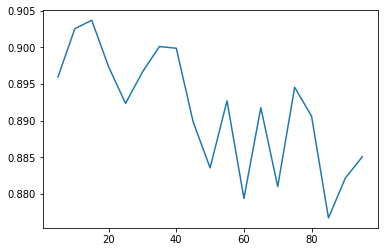

In [204]:
forest_leaf_sel = RandomForestClassifier(random_state=42, n_estimators=10, min_samples_leaf=leaf_lst[np.argmax(leaf_score)])
forest_leaf_featurescore_lst = fs_score(forest_leaf_sel, x_train, y_train)   

In [205]:
print(forest_leaf_featurescore_lst)
print(np.argmax(forest_leaf_featurescore_lst))
print(np.max(forest_leaf_featurescore_lst))

[0.8959574  0.90256106 0.90372014 0.89734843 0.89236534 0.89665305
 0.90012896 0.89989634 0.88981744 0.88356046 0.8927131  0.8793891
 0.89178651 0.88101041 0.89456717 0.89062769 0.87672398 0.8821697
 0.88506771]
2
0.9037201397476249


In [206]:
print_feature(forest_leaf_featurescore_lst, x_train, y_train)

array(['Administrative', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month_Nov',
       'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor'],
      dtype='<U32')

In [207]:
forest_leaf_sel, rf_leaf_sel_select = make_selected_model(forest_leaf_featurescore_lst, forest_leaf_sel, x_train)

In [208]:
x_train_selected_rf_leaf_sel = rf_leaf_sel_select.transform(x_train) 
x_test_selected_rf_leaf_sel = rf_leaf_sel_select.transform(x_test)

In [209]:
rf_leaf_sel_train = forest_leaf_sel.score(x_train_selected_rf_leaf_sel, y_train)
rf_leaf_sel_test = forest_leaf_sel.score(x_test_selected_rf_leaf_sel, y_test)

In [210]:
forest_leaf_sel_score = make_score_df('RF_FS_leaf', y_test, forest_leaf_sel.predict(x_test_selected_rf_leaf_sel), rf_leaf_sel_test, rf_leaf_sel_train)

In [211]:
forest_leaf_sel_score

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,RF_FS_leaf,0.912061,0.904028,0.904028,0.598261,0.735043,0.659636,0.779284


Random Forest model은 feature selection의 적용 유무가 큰 차이가 없다.

# 7. 📌✨Classifier Comparison✨📌

In [212]:
score_df = pd.concat([lr_score, lr_th_score, lr_fs_score, lr_th_fs_score, dt_score, dt_prune_score, dt_fs_score, dt_prune_fs_score,
                      perceptron_score, perceptron_penalty_score, perceptron_fs_score, perceptron_par_sel_score,
                      mlp_score, mlp_par_score, mlp_sel_score, mlp_par_sel_score,
                      knn_score, knn_par_score, knn_sel_score, knn_par_sel_score,
                      rf_score, forest_leaf_score, forest_sel_score, forest_leaf_sel_score],ignore_index=True)
score_df

,model,train,test,accuracy,recall,precesion,f1 score,auc
0,LR,0.886108,0.879157,0.879157,0.349565,0.733577,0.473498,0.663099
1,LR_threshold,0.892828,0.883752,0.883752,0.530435,0.655914,0.586538,NaN
2,LR_FS,0.887035,0.883212,0.883212,0.356522,0.767790,0.486936,0.668338
3,LR_FS_threshold,0.896188,0.891592,0.891592,0.513043,0.709135,0.595358,NaN
4,DT,1.000000,0.852663,0.852663,0.535652,0.525597,0.530577,0.723332
5,DT_prune,0.906847,0.897270,0.897270,0.490435,0.764228,0.597458,0.731293
6,DT_FS,0.985865,0.866991,0.866991,0.535652,0.577861,0.555957,0.731815
7,DT_PRUNE_FS,0.906847,0.897270,0.897270,0.490435,0.764228,0.597458,0.731293
8,Perceptron,0.847874,0.843471,0.843471,0.373913,0.495392,0.426165,0.651905
9,Perceptron_penalty,0.810682,0.802649,0.802649,0.636522,0.412627,0.500684,0.734874


In [213]:
score_df.sort_values(by='test')

,model,train,test,accuracy,recall,precesion,f1 score,auc
9,Perceptron_penalty,0.810682,0.802649,0.802649,0.636522,0.412627,0.500684,0.734874
11,Perceptron_FS_penalty,0.819835,0.825899,0.825899,0.488696,0.445325,0.466003,0.688330
8,Perceptron,0.847874,0.843471,0.843471,0.373913,0.495392,0.426165,0.651905
4,DT,1.000000,0.852663,0.852663,0.535652,0.525597,0.530577,0.723332
16,KNN,0.879736,0.856988,0.856988,0.196522,0.627778,0.299338,0.587537
17,KNN_k,0.864674,0.857529,0.857529,0.121739,0.760870,0.209895,0.557348
6,DT_FS,0.985865,0.866991,0.866991,0.535652,0.577861,0.555957,0.731815
12,MLP,0.997103,0.867532,0.867532,0.551304,0.577413,0.564057,0.738520
21,RF_leaf,0.891322,0.877264,0.877264,0.304348,0.764192,0.435323,0.643531
19,KNN_FS_k,0.893987,0.878886,0.878886,0.361739,0.719723,0.481481,0.667905


In [214]:
score_df.sort_values(by='auc')

,model,train,test,accuracy,recall,precesion,f1 score,auc
17,KNN_k,0.864674,0.857529,0.857529,0.121739,0.760870,0.209895,0.557348
16,KNN,0.879736,0.856988,0.856988,0.196522,0.627778,0.299338,0.587537
21,RF_leaf,0.891322,0.877264,0.877264,0.304348,0.764192,0.435323,0.643531
8,Perceptron,0.847874,0.843471,0.843471,0.373913,0.495392,0.426165,0.651905
0,LR,0.886108,0.879157,0.879157,0.349565,0.733577,0.473498,0.663099
19,KNN_FS_k,0.893987,0.878886,0.878886,0.361739,0.719723,0.481481,0.667905
2,LR_FS,0.887035,0.883212,0.883212,0.356522,0.767790,0.486936,0.668338
11,Perceptron_FS_penalty,0.819835,0.825899,0.825899,0.488696,0.445325,0.466003,0.688330
4,DT,1.000000,0.852663,0.852663,0.535652,0.525597,0.530577,0.723332
5,DT_prune,0.906847,0.897270,0.897270,0.490435,0.764228,0.597458,0.731293


**1. Logistic Regression**
- feature selection을 통해서 3가지의 feature만을 가진 model의 성능이 약 60가지의 feature를 가지는 모델의 성능과 비슷함을 알 수 있다. 또한 가장 기본적인 선형 분류기로도 이 정도의 성능이 나온다는 것을 통해 과제에서 사용한 데이터셋은 어느정도 선형 데이터라고 볼 수 있다. 하지만 auc값을 보면 0.6 정도로 매우 낮은 값을 갖는다. (auc의 최소값은 0.5이다.)

**2. Decision Tree**
- Decision Tree의 경우 feature selection보다 pruning의 영향을 많이 받는 것을 알 수 있다. DT는 feature selection에 상관없이 pruning을 하지 않았을 때 overfitting되지만 pruning을 해주면 overfitting 문제도 해결되고 성능도 향상된다.
- 이는 앞에서도 말했듯이 Decision Tree model의 특징 때문인것 같다. Decision Tree는 feature하나에 하나에 대해 순서대로 data를 분류한다. 따라서 feature selection을 해도 pruning을 하지 않으면 data를 분류하기 위해 feature 값을 계속 잘게 나누기 때문에 overfitting이 계속 발생한다.
- 따라서 pruning 작업은 Decision Tree model에 있어서 매우 중요하고 주어진 데이터셋에 대해서도 3~4 퍼센트의 정확도 향상을 이끌어냈다.
- 또한 auc값도 0.6근처였던 Logistic Regression에 비해 많이 향상됐다.

**3. Perceptron**
- feature selection을 하지 않은 Perceptron model은 84 퍼센트의 정확도를 보이는데 이는 ZERO-R과 별로 다르지 않은 값으로 낮은 성능을 보여준다. 하지만 feature selection을 한 경우 88 퍼센트의 정확도를 보여준다.
- cross-validation을 통해서 penalty를 l1으로 결정했지만, 오히려 정확도는 더 안 좋아졌다.
- 기본 default 모델에 feature selection을 적용하면 auc 값이 좋아지지만, penalty를 바꾼 모델에 feature selection을 적용하면  auc값은 더 안 좋아진다.

**4. Multi-layer Perceptron**
- feature selection을 적용하지 않은 MLP model은 overfitting이 발생했으며 정확도는 약 86 퍼센트이다. 반면에 feature selection을 적용한 MLP model은 overfitting도 발생하지 않았으며 정확도는 89퍼센트로 향상했다.
- 이는 분석에 사용된 데이터셋이 MLP 모델에 사용될 만큼 복잡한 데이터가 아니라고 해석할 수 있다.
- 또한 hidden layer를 줄였을 때 역시 줄이지 않았을 때와 비교하면 overfitting도 없고, 성능도 더 좋다는 것을 알 수 있다. 이는 이 데이터를 분류하는데 hidden layer가 100개까지 있을 필요가 없다는 것을 의미한다.(default MLP모델은 100장의 hideen layer를 가진다.) 즉, hidden layer를 100장 가지는 default model은 데이터에 비해 복잡한 모델이라는 것을 알 수 있다.
- 따라서 feature를 줄이거나 hidden layer를 줄이면 모델의 복잡도가 떨어지기 때문에 더 좋은 결과를 낼 수 있다.
- 또한 대체로 auc 값이 높은 것을 확인할 수 있다.
- 특히 hidden layer를 줄인 모델의 경우, auc 값이 0.8이상의 좋은 값을 낸다.

**5. KNN**
- KNN의 경우 feature selection을 통해 정확도가 85 퍼센트에서 89 퍼센트로 올랐으며 auc도 0.58에서 0.75로 크게 상승했다. 이는 아마 KNN 모델 자체가 feature들 간의 거리로 class를 분류하기 때문인듯 하다. 다른 영향은 거의 받지 않고 대체로 feature의 영향만 받기 때문에 feature의 수를 줄이는 거 자체가 큰 성능향상을 야기하는 듯 하다.
- cross validation을 통해 k값을 정했지만 test data set에 대해서는 대체로 더 낮은 정확도 보인다.

**6. Random Forest**
- randome fores는 DT를 이용하기 때문에 default로 두면 overfitting이 발생할 수 밖에 없다. 따라서 feature selection을 적용해도 pruning을 하지않으면 overfitting이 발생한다.
- 하지만 DT와 다르게 RF는 여러 개의 트리를 만들기 때문에 randomness를 가지게 되고 overfit되더라고 test data set에 대한 성능은 좋은 것이다.
- overfitting 관점에서는 pruning을 한 모델이 더 좋은 성능을 가지지만, auc관점에서는 pruning을 하지 않은 모델이 더 좋은 성능을 보인다.

대부분의 모델이 feature selection에서 택한 feature들은 correlation maxtrix에서 볼 수 있듯이 revenue와 corr값이 큰 feature들이다.

정확도 관점에서는 RF_FS_leaf, MLP_hidden, RF_FS, MLP_FS 순으로 좋은 성능을 보이며, auc 관점에서는 MLP_hidden, RF_FS_leaf, MLP_FS, RF_FS 순으로 좋은 성능을 보인다. auc관점에서나 정확도 관점에서나 위의 4가지 모델이 공통으로 들어있으므로 이들의 성능이 가장 좋다고 볼 수 있다. 특히 hidden layer 수를 줄인 MLP 모델의 경우 auc가 유일하게 0.8을 넘는다.

위의 결과로 보아 분석한 데이터셋은 어느정도 선형성이 있다고 말할 수 있다. 왜냐하면 가장 기본적인 logisitc regression을 통해서도 약 0.88 퍼센트의 정확도를 보이기 때문이다. 또한 MLP에서도 hidden layer를 줄였을 때 더 좋은 성능을 보이는데 이 역시 데이터 셋이 너무 복잡한 데이터가 아님을 보인다.

또한, 위의 모든 방법들은 accuracy 값에 비해 auc 값은 비교적 낮은 값을 갖는데 이는 아마 데이터 자체가 class 0이 더 많은 편향된 데이터이기 때문이다.


또한 feature selection을 했을 때 대부분의 모델이 3개의 feature만 선택했으며 3개 이상을 택하더라도 'ExitRates', 'PageValues', 'Month_Nov'는 항상 선택했는데 이는 revenue와의 상관계수 큰 feature들이다. 이 3가지의 산점도 그래프는 아래와 같다. 이는 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


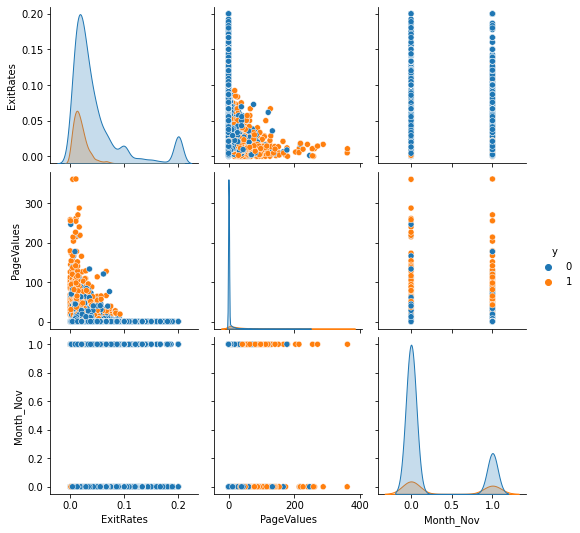

In [215]:
data_most = data[['ExitRates', 'PageValues', 'Month_Nov']]
data_most['y'] = y
sns.pairplot(data_most,hue='y')

# PCA
clustering하기 전에 데이터를 시각화하기 위해서 PCA를 적용한다. 거의 60개에 가까운 feature를 2개로 압축해서 시각화하면 아래와 같다. 그래프를 보면 데이터들이 많이 엉겨있는 것을 알 수 있다.

In [216]:
pca = PCA(n_components=2, random_state=42)
printcipalComponents = pca.fit_transform(x_stand)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

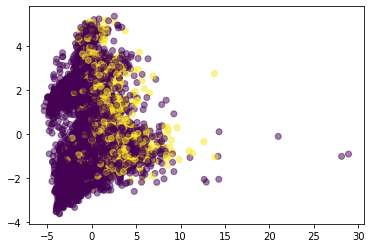

In [217]:
principalDf['y'] = y

plt.scatter(principalDf['principal component1'], principalDf['principal component2'], c = principalDf['y'], alpha=0.5)

# Clustering

## Default

clustering을 한 후에 각 클러스터에 붙여진 label은 그 데이터의 실제 label과는 관련없이 임의로 붙여진 값이다. 따라서 클러스터 label이 0인 경우 그 클러스터의 속한 대부분의 데이터들의 label값이 0이 되도록 바꿔줘야한다.

x_test에 대한 클러스터링 결과와 실제 label인 y_test를 비교하면 위와 같은 표를 얻을 수 있다. 앞의 분류 모델들과 비슷하게 class 0에 대해서는 잘 분류하지만, class 1에 대해서는 그렇지 않다.

In [218]:
kmeans = KMeans(n_clusters=2, random_state=42)   # init = 'random'
kmeans.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [219]:
labels = kmeans.predict(x_test)

count = Counter(labels)
print(count)

for i in range(len(labels)):
  if labels[i] == 0:
    labels[i] = 1
  else:
    labels[i] = 0


Counter({1: 3169, 0: 530})


col_0     0    1
row_0           
0      2728  441
1       396  134


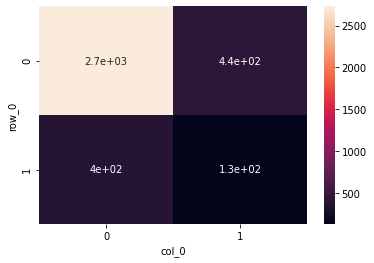

In [220]:
ct = pd.crosstab(labels, y_test)     
print(ct)
sns.heatmap(ct, annot=True)

class 0과 class 1 데이터들이 서로 엉겨있고 대부분의 데이터가 class 0에 속하기 때문에 clustering 결과는 대부분의 데이터를 class 0으로 본다. 따라서 원래 class 1인 데이터도 class 0으로 보는 경우가 많다.

## with Inertias, Select n

<function matplotlib.pyplot.show>

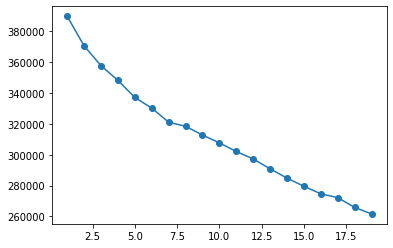

In [221]:
num_clusters = list(range(1, 20))
inertias = []
for k in num_clusters:
  skf = StratifiedKFold(n_splits=5)   # 5 fold     
  val_inertias = np.array([])
  for train_index, val_index in skf.split(x_train, y_train): 
    x_train_cv, x_val_cv = x_train[train_index], x_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

    model = KMeans(n_clusters=k, random_state=42)
    model.fit(x_train_cv)
    val_inertias = np.append(val_inertias, model.inertia_)
  
  inertias.append(model.inertia_.mean())

plt.plot(num_clusters, inertias, '-o')
plt.show

그래프가 계속 감소하는데 목표는 관성이 낮고 군집 수가 가장 적은 것을 찾는 것이다. 하지만 관성이 급격하게 감소하는 부분이 없다. 클러스터링에는 적합하지 않은 데이터일 수도 있다.

## Feature Selection

In [222]:
kmeans_sel = KMeans(n_clusters=2, random_state=42)
kmeans_sel.fit(x_train_selected_lr)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [223]:
labels_lr = kmeans_sel.predict(x_test_selected_lr)

count_lr = Counter(labels_lr)
print(count_lr)

Counter({0: 2817, 1: 882})


col_0     0    1
row_0           
0      2469  348
1       655  227


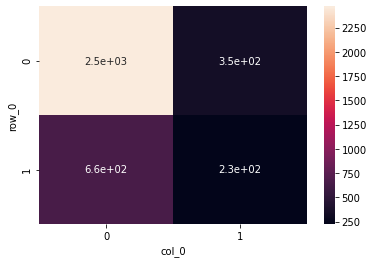

In [224]:
ct_lr = pd.crosstab(labels_lr, y_test)     
print(ct_lr)
sns.heatmap(ct_lr, annot=True)

feature selection을 clustering에 적용해본 결과는 위와 같다. 선택한 feature는 PageValues, ExitRates, BoundRates 3가지이다. 위에서 classifier 모델들이 선택한 feature들 중 이 3가지는 거의 항상 택했고 revenue와 상관계수도 크기 때문에 이 3가지 feature를 택했다. 전체적으로 좀 바뀌었지만 class 1 데이터를 class 1로 택한 경우는 역시나 적다.

In [225]:
kmeans_sel2 = KMeans(n_clusters=2, random_state=42)
kmeans_sel2.fit(x_train_selected_dt)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [226]:
labels_dt = kmeans_sel2.predict(x_test_selected_dt)

count_dt = Counter(labels_dt)
print(count_dt)

Counter({0: 3170, 1: 529})


col_0     0    1
row_0           
0      2729  441
1       395  134


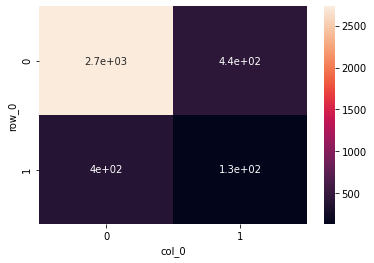

In [227]:
ct_dt = pd.crosstab(labels_dt, y_test)     
print(ct_dt)
sns.heatmap(ct_dt, annot=True)

이번에는 DT에서 선택한 feature들을 선택해보았다. Administrative, ProductRelated, ProductRelated_Duration, BounceRates, ExitRates, PageValues, Month_Nov, VisitorType_New_Visitor 그리고 VisitorType_Returning_Visitor를 택했다. 역시나 class 1의 데이터에 대해 class 1로 분류하는 경우가 매우 적다.

# Classification vs. Clustering
default clustering과 classifier의 비교하려 한다.

In [228]:
def model_vs_clustering(model, model_name, x_test):
  y_pred = model.predict(x_test)

  df = pd.DataFrame({'predict': labels, model_name: y_pred})
  ct = pd.crosstab(df['predict'], df[model_name])
  print(ct)
  print("---------- ### ----------")
  print(classification_report(labels, y_pred))
  sns.heatmap(ct, annot=True)

위의 함수는 분류모델과 군집 모델의 비교를 위한 함수이다. clustering으로 분류한 label과 classification으로 분류한 label를 비교하고 시각화한다.

## 1. Logistic Regression

LR          0    1
predict           
0        2972  197
1         453   77
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3169
           1       0.28      0.15      0.19       530

    accuracy                           0.82      3699
   macro avg       0.57      0.54      0.55      3699
weighted avg       0.78      0.82      0.80      3699



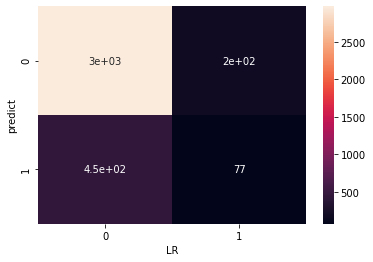

In [229]:
model_vs_clustering(logistic, 'LR', x_test)

## 2. Decision Tree

DT          0    1
predict           
0        2713  456
1         400  130
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3169
           1       0.22      0.25      0.23       530

    accuracy                           0.77      3699
   macro avg       0.55      0.55      0.55      3699
weighted avg       0.78      0.77      0.77      3699



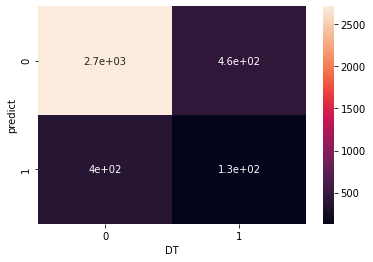

In [230]:
model_vs_clustering(dtclassifier, 'DT', x_test)

DT_prune     0    1
predict            
0         2896  273
1          434   96
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3169
           1       0.26      0.18      0.21       530

    accuracy                           0.81      3699
   macro avg       0.56      0.55      0.55      3699
weighted avg       0.78      0.81      0.79      3699



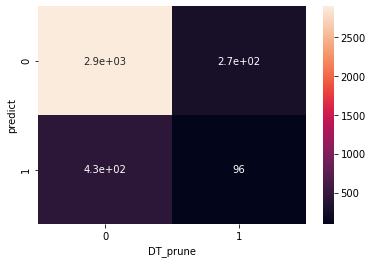

In [231]:
model_vs_clustering(prune_classifier, 'DT_prune', x_test)

DT_FS       0    1
predict           
0        2727  442
1         439   91
---------- ### ----------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3169
           1       0.17      0.17      0.17       530

    accuracy                           0.76      3699
   macro avg       0.52      0.52      0.52      3699
weighted avg       0.76      0.76      0.76      3699



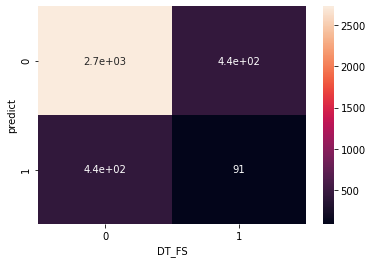

In [232]:
model_vs_clustering(dtclassifier_sel, 'DT_FS', x_test_selected_dt_only)

DT_FS_prune     0    1
predict               
0            2896  273
1             434   96
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3169
           1       0.26      0.18      0.21       530

    accuracy                           0.81      3699
   macro avg       0.56      0.55      0.55      3699
weighted avg       0.78      0.81      0.79      3699



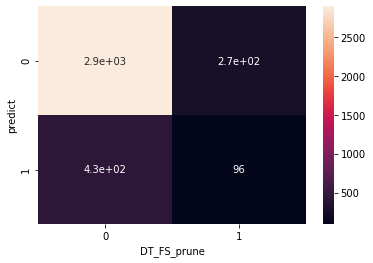

In [233]:
model_vs_clustering(prune_classifier_sel, 'DT_FS_prune', x_test_selected_dt)

## 3. Perceptron

perceptron     0    1
predict              
0           2847  322
1            418  112
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      3169
           1       0.26      0.21      0.23       530

    accuracy                           0.80      3699
   macro avg       0.57      0.55      0.56      3699
weighted avg       0.78      0.80      0.79      3699



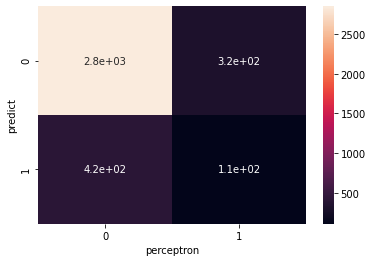

In [234]:
model_vs_clustering(perceptron, 'perceptron', x_test)

perceptron_penalty     0    1
predict                      
0                   2454  715
1                    358  172
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3169
           1       0.19      0.32      0.24       530

    accuracy                           0.71      3699
   macro avg       0.53      0.55      0.53      3699
weighted avg       0.78      0.71      0.74      3699



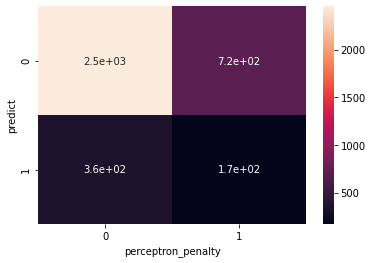

In [235]:
model_vs_clustering(perceptron_par, 'perceptron_penalty', x_test)

Perceptron_FS     0    1
predict                 
0              2829  340
1               431   99
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3169
           1       0.23      0.19      0.20       530

    accuracy                           0.79      3699
   macro avg       0.55      0.54      0.54      3699
weighted avg       0.78      0.79      0.78      3699



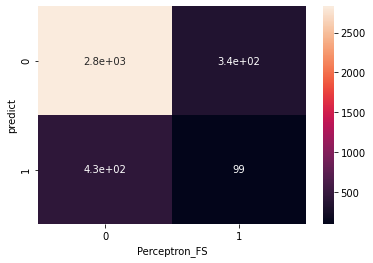

In [236]:
model_vs_clustering(perceptron_sel, 'Perceptron_FS', x_test_selected_pct_fs)

perceptron_FS_penalty     0    1
predict                         
0                      2629  540
1                       439   91
---------- ### ----------
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3169
           1       0.14      0.17      0.16       530

    accuracy                           0.74      3699
   macro avg       0.50      0.50      0.50      3699
weighted avg       0.75      0.74      0.74      3699



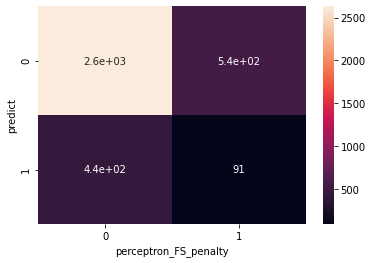

In [237]:
model_vs_clustering(perceprton_par_sel, 'perceptron_FS_penalty', x_test_selected_pct)

## 4. MLP

MLP         0    1
predict           
0        2749  420
1         401  129
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3169
           1       0.23      0.24      0.24       530

    accuracy                           0.78      3699
   macro avg       0.55      0.56      0.55      3699
weighted avg       0.78      0.78      0.78      3699



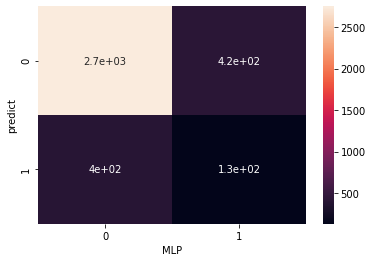

In [238]:
model_vs_clustering(mlp, 'MLP', x_test)

MLP_hidden     0    1
predict              
0           2665  504
1            416  114
---------- ### ----------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3169
           1       0.18      0.22      0.20       530

    accuracy                           0.75      3699
   macro avg       0.52      0.53      0.53      3699
weighted avg       0.77      0.75      0.76      3699



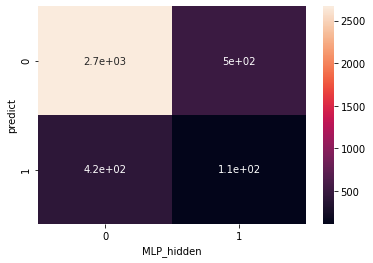

In [239]:
model_vs_clustering(mlp_par, 'MLP_hidden', x_test)

MLP_FS      0    1
predict           
0        2810  359
1         416  114
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3169
           1       0.24      0.22      0.23       530

    accuracy                           0.79      3699
   macro avg       0.56      0.55      0.55      3699
weighted avg       0.78      0.79      0.79      3699



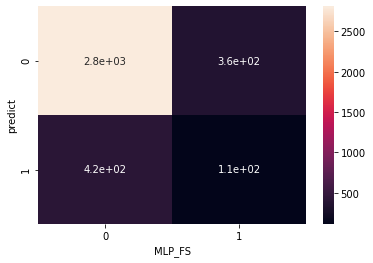

In [240]:
model_vs_clustering(mlp_sel, 'MLP_FS', x_test_selected_mlp_sel)

MLP_FS_hidden     0    1
predict                 
0              2812  357
1               414  116
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3169
           1       0.25      0.22      0.23       530

    accuracy                           0.79      3699
   macro avg       0.56      0.55      0.56      3699
weighted avg       0.78      0.79      0.79      3699



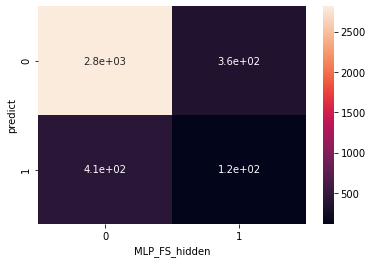

In [241]:
model_vs_clustering(mlp_par_sel, 'MLP_FS_hidden', x_test_selected_mlp_par_sel)

## 5. KNN

KNN         0    1
predict           
0        3036  133
1         483   47
---------- ### ----------
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3169
           1       0.26      0.09      0.13       530

    accuracy                           0.83      3699
   macro avg       0.56      0.52      0.52      3699
weighted avg       0.78      0.83      0.80      3699



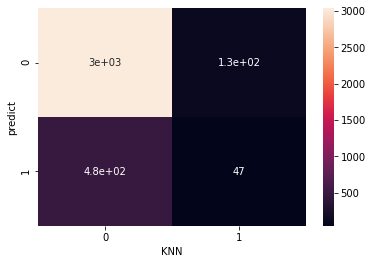

In [242]:
model_vs_clustering(knn, 'KNN', x_test)

KNN_k       0   1
predict          
0        3113  56
1         494  36
---------- ### ----------
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      3169
           1       0.39      0.07      0.12       530

    accuracy                           0.85      3699
   macro avg       0.63      0.53      0.52      3699
weighted avg       0.80      0.85      0.80      3699



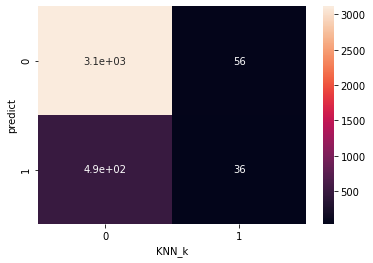

In [243]:
model_vs_clustering(knnk, 'KNN_k', x_test)

KNN_FS      0    1
predict           
0        2820  349
1         423  107
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3169
           1       0.23      0.20      0.22       530

    accuracy                           0.79      3699
   macro avg       0.55      0.55      0.55      3699
weighted avg       0.78      0.79      0.78      3699



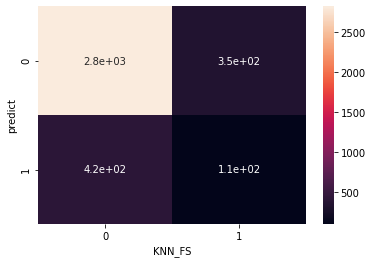

In [244]:
model_vs_clustering(knn_sel, 'KNN_FS', x_test_selected_knn_sel)

KNN_FS_k     0    1
predict            
0         2950  219
1          460   70
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3169
           1       0.24      0.13      0.17       530

    accuracy                           0.82      3699
   macro avg       0.55      0.53      0.53      3699
weighted avg       0.78      0.82      0.79      3699



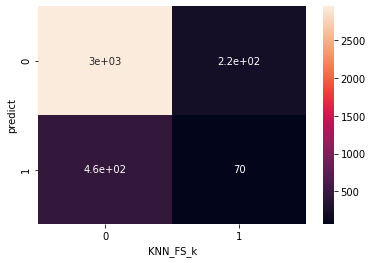

In [245]:
model_vs_clustering(knn_par_sel, 'KNN_FS_k', x_test_selected_knn_par_sel)

## 6. RandomForest

RF          0    1
predict           
0        2890  279
1         416  114
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3169
           1       0.29      0.22      0.25       530

    accuracy                           0.81      3699
   macro avg       0.58      0.56      0.57      3699
weighted avg       0.79      0.81      0.80      3699



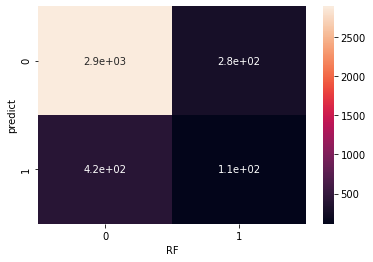

In [246]:
model_vs_clustering(forest, 'RF', x_test)

RF_leaf     0    1
predict           
0        3011  158
1         459   71
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3169
           1       0.31      0.13      0.19       530

    accuracy                           0.83      3699
   macro avg       0.59      0.54      0.55      3699
weighted avg       0.79      0.83      0.80      3699



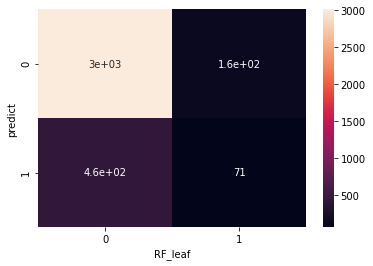

In [247]:
model_vs_clustering(forest_leaf, 'RF_leaf', x_test)

RF_FS       0    1
predict           
0        2867  302
1         415  115
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      3169
           1       0.28      0.22      0.24       530

    accuracy                           0.81      3699
   macro avg       0.57      0.56      0.57      3699
weighted avg       0.79      0.81      0.80      3699



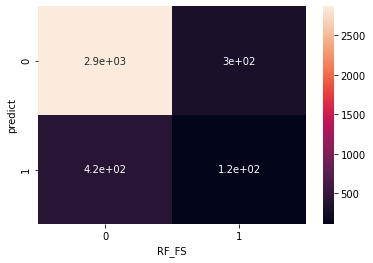

In [248]:
model_vs_clustering(forest_sel, 'RF_FS', x_test_selected_rf_sel)

RF_FS_leaf     0    1
predict              
0           2815  354
1            416  114
---------- ### ----------
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3169
           1       0.24      0.22      0.23       530

    accuracy                           0.79      3699
   macro avg       0.56      0.55      0.55      3699
weighted avg       0.78      0.79      0.79      3699



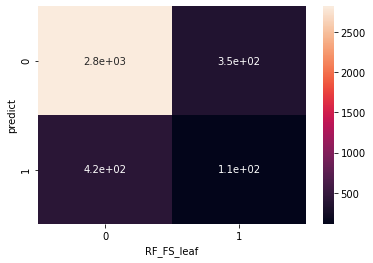

In [249]:
model_vs_clustering(forest_leaf_sel, 'RF_FS_leaf', x_test_selected_rf_leaf_sel)

class 0에 대해서는 classifier 모델이 분류한 것과 clustring이 분류한 것이 비슷하게 나오지만, class 1에 대해서는 clustering과 다르게 나오는 경우가 더 많다.

clustering도 class 1로 분류하고, classifier도 class 1로 분류하는 경우가 가장 적은데 이는 데이터 자체가 class 0인 데이터가 더 많기 때문이다.

default KNN과 random forest model 그리고, KNN의 k를 조정한 model들이 clustering결과와 가장 유사하게 나왔는데, 이는 KNN과 RF가 다른 모델들과는 다르게 데이터 자체를 보고 분류하기 때문이다. 또한 clustering은 feature selection을 적용하지 않았기 때문에 feature selection을 적용한 classifier model과는 더 큰 차이를 보인다.

# 📌Conclusion
결론적으로 MLP의 hidden layer 수를 줄인 모델과 그 모델에 feature selection을 적용한 모델, RF에서 어느정도 pruning을 한 모델과 그 모에 feature selection을 적용한 모델의 성능이 accuracy 관점에서도 auc 관점에서도 가장 좋았다.
- accuracy 관점에서는 RF_FS_leaf이 가장 좋다.
- auc 관점에서는 MLP_hidden이 유일하게 0.8을 넘으며 가장 좋다.
- hidden layer를 줄인 MLP model의 성능이 좋다는 것은 데이터가 그만큼 복잡하지 않다고 해석할 수 있다.
- RF를 pruning하지 않으면 leaf 노드에 하나의 원소만 남을 때까지 분류 하기 때문에 overfitting이 발생할 수 밖에 없다.(DT도 마찬가지이다.) 따라서 pruning을 한 모델의 성능이 더 좋다. 
- 하지만 위에서도 말했듯이 DT와는 다르게 randomness를 가지고 있어서 overfit되더라도 성능은 괜찮다.
- Logistic Regression model의 성능도 88퍼센트 (accuracy)로 나쁘지 않기 때문에 사용한 데이터셋은 선형성을 가지고 있다고 볼 수 있다.
- cross-validation을 통해 parameter를 정해도 test data set에 대해서는 더 안 좋은 성능을 만들 수도 있다.